## Linear Regression (n_s = 1)

In [ ]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error

def fit_LR_cv(X, y, cv_in, seed = 10):
    # Initialize a Linear Regression model
    model = LinearRegression(random_state = seed)

    # Perform cross-validation and calculate scores
    scores = cross_val_score(model, X, y, cv=cv_in, scoring=make_scorer(mean_squared_error))

    # Fit the model using all data
    model.fit(X, y)

    # Return the trained model
    return model, scores

def fit_elasticNet_cv(X, y, cv_in, seed = 10):
    # Initialize a Linear Regression model
    model = ElasticNet(random_state = seed)

    # Perform cross-validation and calculate scores
    scores = cross_val_score(model, X, y, cv=cv_in, scoring=make_scorer(mean_squared_error))

    # Fit the model using all data
    model.fit(X, y)

    # Return the trained model
    return model, scores


import optuna
import pandas as pd
import seaborn as sns
import warnings
import BehavUtils as butils
import glob
from natsort import natsorted
import time
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score


numTrials = 100
nSplits = 5
scores_cv = np.full(numTrials, np.nan)

dats_train = np.load('Predictors_emissions_mouse_concat_train.npz', allow_pickle = True)
dat_train_final = dats_train['predictors']
dat_train_final = dat_train_final[:,0].reshape(-1,1)
y_train_final = dats_train['emissions']
y_train_final[y_train_final>4] = 4

start2 = time.time()

btscv = butils.BlockingTimeSeriesSplit(n_splits=nSplits)

siz = int(0.8*y_train_final.shape[0])
def objective(trial):
    """Objective function to be optimized by Optuna. 
    Inputs:
        - trial (optuna.trial._trial.Trial): Optuna trial
    Returns:
        - RMSE(torch.Tensor): The test RMSE. Parameter to be minimized.
    """

    # Define range of values to be tested for the model hyperparameters.
    alpha = trial.suggest_float("alpha", 0, 100)            
    
    # Initialize a Lasso regression
    model = SGDRegressor(penalty = 'l2', alpha = alpha, learning_rate = 'optimal', max_iter=10000, tol=0.001, shuffle = False)

    # List to store the performance for each fold
    scor_list = []

    # Iterate over each split
    for train_index, test_index in btscv.split(dat_train_final):
        X_train, X_test = dat_train_final[train_index], dat_train_final[test_index]
        y_train, y_test = y_train_final[train_index], y_train_final[test_index]

        # Fit the model
        model.fit(X_train, y_train.reshape(-1,))

        # Make predictions
        y_pred = model.predict(X_test)

        # Compute RMSE and add it to the list
        scor = r2_score(y_test, y_pred)
        scor_list.append(scor)
    

    # Init tracking experiment hyper-parameters, trial id are stored.
    config = dict(trial.params)
    config["trial.number"] = trial.number

    return np.nanmean(scor_list)


if __name__ == '__main__':

    # --- Parameters ----------------------------------------------------------

    number_of_trials = 100                  # Number of Optuna trials

    # Create an Optuna study to minimize the RMSE, using CV.
    sampler = optuna.samplers.CmaEsSampler()
    study = optuna.create_study(direction = "maximize")#, sampler = sampler)
    study.optimize(objective, n_trials = number_of_trials, gc_after_trial=True)

    # Save results to csv file
    df = study.trials_dataframe().drop(['datetime_start', 'datetime_complete', 'duration'], axis=1)  # Exclude columns
    df = df.loc[df['state'] == 'COMPLETE']          # Keep only results that did not prune
    df = df.drop('state', axis=1)                   # Exclude state column
    df = df.sort_values('value')                    # Sort based on performance

    # Find the most important hyperparameters
    most_important_parameters = optuna.importance.get_param_importances(study, target=None)

    scores_cv = df['value'].values
    selected_alpha = list(study.best_trial.params.values())

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score

dat = np.load('Predictors_emissions_macaque_concat_train.npz', allow_pickle = True)
dat_train_final_macaque = dat['predictors']
dat_train_final_macaque = dat_train_final_macaque[:,0].reshape(-1,1)
y_train_final_macaque = dat['emissions']

siz = int(0.8*y_train_final_macaque.shape[0])
def objective(trial):
    """Objective function to be optimized by Optuna. 
    Inputs:
        - trial (optuna.trial._trial.Trial): Optuna trial
    Returns:
        - RMSE(torch.Tensor): The test RMSE. Parameter to be minimized.
    """

    # Define range of values to be tested for the model hyperparameters.
    alpha = trial.suggest_float("alpha", 0, 100)            
    
    # Initialize an ElasticNet model
    #model = ElasticNet(alpha = alpha, l1_ratio = l1_ratio, precompute=False, max_iter=10000, tol=0.0001)
    model = SGDRegressor(penalty = 'l2', alpha = alpha, learning_rate = 'optimal', max_iter=10000, tol=0.001, shuffle = False)

    # List to store the performance for each fold
    scor_list = []

    # Iterate over each split
    for train_index, test_index in btscv.split(dat_train_final_macaque):
        X_train, X_test = dat_train_final_macaque[train_index], dat_train_final_macaque[test_index]
        y_train, y_test = y_train_final_macaque[train_index], y_train_final_macaque[test_index]

        # Fit the model
        model.fit(X_train, y_train.reshape(-1,))

        # Make predictions
        y_pred = model.predict(X_test)

        # Compute RMSE and add it to the list
        scor = r2_score(y_test, y_pred)
        scor_list.append(scor)
    

    # Init tracking experiment hyper-parameters, trial id are stored.
    config = dict(trial.params)
    config["trial.number"] = trial.number

    return np.nanmean(scor_list)


if __name__ == '__main__':

    # --- Parameters ----------------------------------------------------------

    number_of_trials = 100                  # Number of Optuna trials

    # Create an Optuna study to minimize the RMSE, using CV.
    sampler = optuna.samplers.CmaEsSampler()
    study = optuna.create_study(direction = "maximize")#, sampler = sampler)
    study.optimize(objective, n_trials = number_of_trials, gc_after_trial=True)

    # Save results to csv file
    df = study.trials_dataframe().drop(['datetime_start', 'datetime_complete', 'duration'], axis=1)  # Exclude columns
    df = df.loc[df['state'] == 'COMPLETE']          # Keep only results that did not prune
    df = df.drop('state', axis=1)                   # Exclude state column
    df = df.sort_values('value')                    # Sort based on performance

    # Find the most important hyperparameters
    most_important_parameters = optuna.importance.get_param_importances(study, target=None)

    scores_cv_macaque = df['value'].values
    selected_alpha = list(study.best_trial.params.values())

In [ ]:
import glob
import numpy as np
from natsort import natsorted
import seaborn as sns
import matplotlib.pyplot as plt
import matplotx as mpx

def darken_color(color, factor=0.5):
    from matplotlib.colors import to_rgb, to_hex

    # Convert the color to an RGB tuple if it's in string format
    rgb_color = to_rgb(color)

    # Darken the color by the factor
    darkened_rgb = tuple([max(0, c - factor*(1-c)) for c in rgb_color])

    return to_hex(darkened_rgb)

files_results_macaque_fullModel = natsorted(glob.glob('Results/Macaque/Results_CV_sLDS_Optuna_macaque_100trials_*_states_28112023_RT_noLEyeBrModel_AllSubjects_R2score_CVOnly.npz', recursive = True))
cv_scores_macaque_fullModel = np.zeros((len(files_results_macaque_fullModel), 100))

for ii, file in enumerate(files_results_macaque_fullModel):
    a = np.load(file, allow_pickle = True)
    cv_scores_macaque_fullModel[ii, :] =  a[a.files[0]][()].copy()


files_results_mouse_fullModel = natsorted(glob.glob('Results/Mouse/Results_CV_MSLR_Optuna_mouse_newDLC_100trials_*_states_24022024_RT_AllSubjects_R2score_CVOnly.npz', recursive = True))

cv_scores_mouse_fullModel = np.zeros((len(files_results_mouse_fullModel), 100))
for ii, file in enumerate(files_results_mouse_fullModel):
    a = np.load(file, allow_pickle = True)
    keyss = list(a.keys())
    cv_scores_mouse_fullModel[ii, :] =  a[a.files[0]][()].copy()
cv_scores_mouse_fullModel[cv_scores_mouse_fullModel<-100] = 0

cv_lr_macaque =  np.load('LassoReg_macaque_03062023_RT_AllSubjects_R2score_CVOnly.npy')
cv_lr_mouse =  np.load('LassoReg_mouse_03062023_RT_AllSubjects_R2score_CVOnly.npy')

In [2]:
def darken_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


def plot_cv_states(scores_macaque, scores_mouse, ax, colors, marker, saveFig = False, figName = 'Results/mockTitle.png'):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotx as mpx

    meds_macaque = np.nanmax(scores_macaque,axis = 1)
    meds_mouse = np.nanmax(scores_mouse,axis = 1)
    
    # Calculate standard deviations
    std_low_macaque = np.nanpercentile(scores_macaque, 5, axis=1)
    std_low_mouse = np.nanpercentile(scores_mouse, 5, axis=1)

    meds = [meds_macaque, meds_mouse]
    std_low = [std_low_macaque, std_low_mouse]
    # Plot medians and stds
    for ii, axi in enumerate(ax.flat):

        x = np.arange(meds[ii].shape[0])+2
        axi.plot(x, meds[ii], color=darken_color(colors[ii], 0.7), mfc=colors[ii], ms=8, mew=1, marker = marker)
        axi.fill_between(x, std_low[ii], meds[ii], color=colors[ii], alpha = 0.5)
        axi.set_ylim([0, 1])
        axi.set_ylabel('$R^2$ (Cross-Val)', fontsize=16)
        axi.set_xlabel('# internal states', fontsize=16)

        xtiks = np.arange(2, meds[ii].shape[0] + 2)[::2]
        axi.set_xticks(xtiks)
        axi.set_xticklabels(xtiks, fontsize=14)
        axi.set_yticks(np.linspace(0, 1, 3), np.linspace(0, 1, 3), fontsize = 14)
        axi.set_xlim([1.5, meds[ii].shape[0]+1.5])
    plt.tight_layout()
    if saveFig:
        plt.savefig(figName, transparent = True)

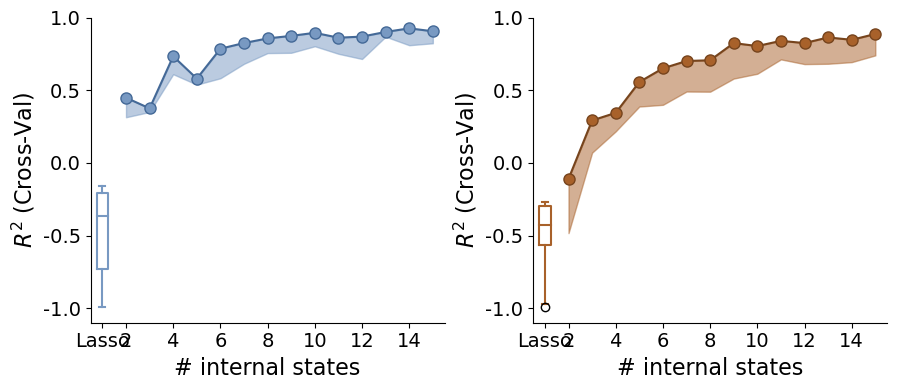

In [3]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 4))
sns.despine()
colors = ['#7899c2ff', '#A8612A']
#plot_cv_states(cv_scores_macaque_fullModel, cv_scores_mouse_fullModel_old, ax, colors = ['gray']*2, marker = 'o')
plot_cv_states(cv_scores_macaque_fullModel, cv_scores_mouse_fullModel, ax, colors = colors, marker = 'o')

for (ii, axi), scors in zip(enumerate(ax.flat), [cv_lr_macaque, cv_lr_mouse]):
    box = axi.boxplot(scors, positions = [1], widths = 0.5)
    for element in ['boxes', 'whiskers', 'caps', 'medians']:
        plt.setp(box[element], color=colors[ii])
        plt.setp(box[element], lw=1.5)

for axi in ax:
    axi.set_ylim(-1.1, 1)
    axi.set_xlim(0.5, 15.5)
    xtiks = np.concatenate([[1], np.arange(2, cv_scores_macaque_fullModel.shape[0] + 2)[::2]])
    axi.set_xticks(xtiks)
    axi.set_yticks(np.linspace(-1,1,5), np.linspace(-1,1,5))
    axi.set_xticklabels(np.concatenate([['Lasso'], np.arange(2, cv_scores_macaque_fullModel.shape[0] + 2)[::2]]), fontsize=14)
#plt.savefig('Results/BothSpecies_AllSubjects_numStates_R2_CV_RT_27022024.svg', transparent = True)

In [ ]:
import glob
import numpy as np
from natsort import natsorted
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

selected_variables_mouse = ['PupilSize', 'EyeMov', 'NoseMov', 'Eye [x]', 'Eye [y]', 'Nose [x]', 'Nose [y]', 'Whiskers [x]', 'Whiskers [y]']
all_vars_macaque  = ['PupSize', 'EyeMov', 'Eye_x', 'Eye_y', 'rEar_x', 'rEar_y', 'lEar_x', 'lEar_y', 'rEyeBr_x', 'rEyeBr_y', 'lEyeBr_x', 
                     'lEyeBr_y', 'nostrils_x', 'nostrils_y', 'uLip_x', 'uLip_y', 'lLip_x', 'lLip_y']
newOrder_mouse = np.array([0, 1, 3, 4, 2, 5, 6, 7, 8])
newOrder_macaque = np.array([0,1,2,3,8,9,10,11, 12, 13, 14, 15, 16, 17, 4,  5,  6,  7])

cols_macaque = sns.color_palette(["#52ef99", "#146c45", "#778DF9", '#40C7B0', "#aae3a4", '#2A7958', "#21638f", '#516578', "#3aa609", '#4B8AC7', '#2D4EF7'])
cols_mouse = sns.color_palette(["#5a3386", '#FF8C80', "#8c75d2", '#FBA984', "#940393", '#FE9E47', "#e9b7e3", "#cf60f3", "#ff66b2", sns.desaturate("#ff66b2", 0.5), '#FF8C80'])

#stat_labs = [np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G']), np.array(['A', 'B', 'C', 'D', 'E', 'F'])]
stat_labs = [np.array(['A', 'B', 'C', 'D']), np.array(['A', 'B', 'C'])]

date = '11122023'

files_results_macaque = natsorted(glob.glob('Results/Macaque/Results_Test_sLDS_Optuna_macaque_100trials_'+date+'_RT_noLEyeBrModel_AllSubjects_session*.npz', recursive = True))
files_results_mouse = natsorted(glob.glob('Results/Mouse/Results_Test_sLDS_Optuna_mouse_50trials_'+date+'_RT_noEyeMovModel_AllSubjects_session*.npz', recursive = True))

perf_macaque = np.full(len(files_results_macaque), np.nan)
perf_mouse = np.full(len(files_results_mouse), np.nan)

for i, file in enumerate(files_results_macaque):
    a = np.load(file, allow_pickle = True)
    preds = np.array(a[a.files[0]][()]['predictions'])
    preds[preds<0] = 0
    perf_macaque[i] = r2_score(a[a.files[0]][()]['y_test'], preds)


for i, file in enumerate(files_results_mouse):
    a = np.load(file, allow_pickle = True)
    preds = np.array(a[a.files[0]][()]['predictions'])
    preds[preds<0] = 0
    perf_mouse[i] = r2_score(a[a.files[0]][()]['y_test'], preds)


In [ ]:
r2_lr_macaque =  np.load('LassoReg_macaque_03062023_RT_AllSubjects_R2score_CVOnly.npy')
r2_lr_mouse =  np.load('LassoReg_mouse_03062023_RT_AllSubjects_R2score_CVOnly.npy')

animals_colors = ['#7899c2ff', '#A8612A']

pal_mac = sns.color_palette([animals_colors[0], sns.desaturate(animals_colors[0], 0.2)])
pal_mous = sns.color_palette([animals_colors[1], sns.desaturate(animals_colors[1], 0.2)])
fig, ax = plt.subplots(ncols = 2, figsize=(8,4))
sns.despine()
# Matplotlib boxplot with position control
sns.boxplot(data = [r2_lr_macaque, scores_cv_macaque], palette = pal_mac, showfliers = False, ax = ax[0])
sns.boxplot(data = [r2_lr_mouse, scores_cv], palette = pal_mous, showfliers = False, ax = ax[1])

titls = ['Macaque', 'Mouse']
for ii, axi in enumerate(ax):
    axi.set_xticks(ticks = np.arange(2), labels = ['Face', 'Pupil'], fontsize = 20, rotation = 30)
    axi.set_yticks(ticks = np.linspace(-1., 1, 5), labels = ['{:.1f}'.format(a) for a in np.linspace(-1., 1, 5)], fontsize = 18)
    axi.set_ylabel('Test $R^2$', fontsize = 20)
    axi.set_ylim(-1,1)
    axi.set_title(titls[ii], fontsize = 20)
plt.tight_layout()
plt.savefig('Results/BothSpecies_AllSubjects_R2_Test_RT_FacesVsPupil_noSwitching_22112023.svg', transparent = True)

## Pupil size removal

In [ ]:
import glob
import numpy as np
from natsort import natsorted
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

cols_macaque = sns.color_palette(["#52ef99", "#146c45", "#778DF9", '#40C7B0', "#aae3a4", '#2A7958', "#21638f", '#516578', "#3aa609", '#4B8AC7', '#2D4EF7'])
cols_mouse = sns.color_palette(["#5a3386", '#FF8C80', "#8c75d2", '#FBA984', "#940393", '#FE9E47', "#e9b7e3", "#cf60f3", "#ff66b2", sns.desaturate("#ff66b2", 0.5), '#FF8C80'])


numTrials = 100
date_full = '11122023'
date_removedFeatures = '13122023'
date_removedFeatures_2 = '12112024'

files_results_macaque = natsorted(glob.glob('Results/Macaque/*'+str(numTrials)+'trials_'+date_full+'_RT_noLEyeBrModel_AllSubjects_session*.npz', recursive = True))
files_results_mouse = natsorted(glob.glob('Results/Mouse/*'+str(50)+'trials_'+date_full+'_RT_noEyeMovModel_AllSubjects_session*.npz', recursive = True))

perf_macaque_full = np.full(len(files_results_macaque), np.nan)
perf_mouse_full = np.full(len(files_results_mouse), np.nan)

for i, file in enumerate(files_results_macaque):
    a = np.load(file, allow_pickle = True)
    preds = np.array(a[a.files[0]][()]['predictions'])
    preds[preds<0] = 0
    perf_macaque_full[i] = r2_score(a[a.files[0]][()]['y_test'], preds)


for i, file in enumerate(files_results_mouse):
    a = np.load(file, allow_pickle = True)
    preds = np.array(a[a.files[0]][()]['predictions'])
    preds[preds<0] = 0
    perf_mouse_full[i] = r2_score(a[a.files[0]][()]['y_test'], preds)

files_results_macaque_noPupil = natsorted(glob.glob('Results/Macaque/*'+str(numTrials)+'trials_'+date_removedFeatures+'_RT_noPupilModel_AllSubjects_session*.npz', recursive = True))
files_results_macaque_noPupilnoEyeMov = natsorted(glob.glob('Results/Macaque/*'+str(numTrials)+'trials_'+date_removedFeatures_2+'_RT_noPupilnoEyeMovModel_AllSubjects_session*.npz', recursive = True))
files_results_mouse_noPupil = natsorted(glob.glob('Results/Mouse/*'+str(numTrials)+'trials_'+date_removedFeatures+'_RT_noPupilModel_AllSubjects_session*.npz', recursive = True))

perf_macaque_noPupil = np.zeros(len(files_results_macaque_noPupil))
perf_macaque_noPupilnoEyeMov = np.zeros(len(files_results_macaque_noPupilnoEyeMov))
perf_mouse_noPupil = np.zeros(len(files_results_mouse_noPupil))
y_test_macaque = []
y_pred_macaque = []
for rr, file in enumerate(files_results_macaque_noPupil):
    a = np.load(file, allow_pickle = True)
    preds = np.array(a[a.files[0]][()]['predictions'])
    preds[preds<0] = 0
    perf_macaque_noPupil[rr] = r2_score(a[a.files[0]][()]['y_test'], preds)


for rr, file in enumerate(files_results_macaque_noPupilnoEyeMov):
    a = np.load(file, allow_pickle = True)
    preds = np.array(a[a.files[0]][()]['predictions'])
    preds[preds<0] = 0
    perf_macaque_noPupilnoEyeMov[rr] = r2_score(a[a.files[0]][()]['y_test'], preds)


for rr, file in enumerate(files_results_mouse_noPupil):
    a = np.load(file, allow_pickle = True)
    preds = np.array(a[a.files[0]][()]['predictions'])
    preds[preds<0] = 0
    perf_mouse_noPupil[rr] = r2_score(a[a.files[0]][()]['y_test'], preds)

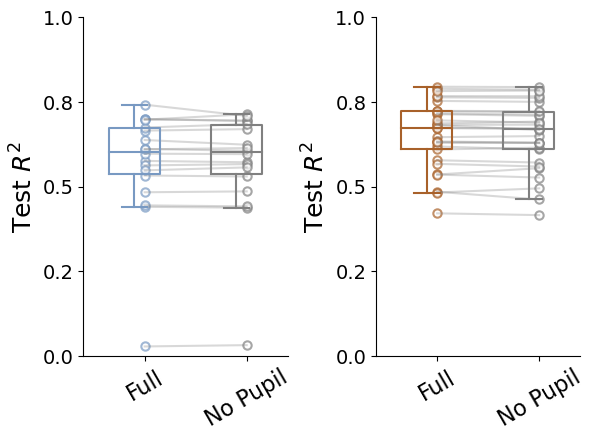

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize=(6,4))
sns.despine()
colors = ['#7899c2ff', '#A8612A']

def plot_test_performance(performance, position, color, ax, saveFig = False, figName = 'mockTest.png'):

    box = ax.boxplot(performance, showfliers = False, widths=0.5, positions = position)

    # Customize boxplot colors
    for element in ['boxes', 'whiskers', 'caps', 'medians']:
        plt.setp(box[element], color=color)
        plt.setp(box[element], lw=1.5)
    
    # Add stripplots for the gray points
    ax.scatter(x = len(performance)*[0.1+position[0]], y = performance, color = color, facecolor = 'white', lw = 1.5, alpha = 0.7)#+0.15*np.random.random(size = performance.shape[0])
    ax.set_yticks(ticks = np.linspace(0, 1, 5), labels = ['{:.1f}'.format(a) for a in np.linspace(0, 1, 5)], fontsize = 14)
    ax.set_ylabel('Test $R^2$', fontsize = 18)
    ax.set_ylim(0,1)
    #ax.set_xlim(-0.5, 1.5)
    plt.tight_layout()
    if saveFig:
        plt.savefig(figName, transparent = True)

for ii in range(perf_macaque_full.shape[0]):
    ax[0].plot([0.1, 1.1], [perf_macaque_full[ii], perf_macaque_noPupilnoEyeMov[ii]], color = 'gray', alpha = 0.3)
plot_test_performance(perf_macaque_full, position = [0], color = colors[0], ax = ax[0])
plot_test_performance(perf_macaque_noPupilnoEyeMov, position = [1], color = 'gray', ax = ax[0])
for ii in range(perf_mouse_full.shape[0]):
    ax[1].plot([0.1, 1.1], [perf_mouse_full[ii], perf_mouse_noPupil[ii]], color = 'gray', alpha = 0.3)
plot_test_performance(perf_mouse_full, position = [0], color = colors[1], ax = ax[1])
plot_test_performance(perf_mouse_noPupil, position = [1], color = 'gray', ax = ax[1])
for axi in ax:
    axi.set_xticks(ticks = np.arange(2)+0.1, labels = ['Full', 'No Pupil'], fontsize = 16, rotation = 30)
#plt.savefig('Results/FullModel_vs_NoPupil_29082024.pdf', transparent = True)

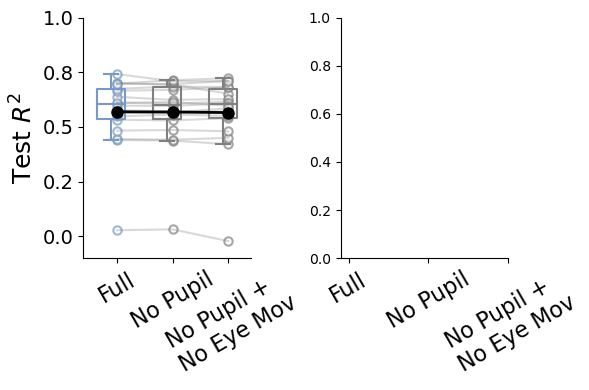

In [12]:
fig, ax = plt.subplots(ncols = 2, figsize=(6,4))
sns.despine()
colors = ['#7899c2ff', '#A8612A']

def plot_test_performance(performance, position, color, ax, saveFig = False, figName = 'mockTest.png'):

    box = ax.boxplot(performance, showfliers = False, widths=0.5, positions = position)

    # Customize boxplot colors
    for element in ['boxes', 'whiskers', 'caps', 'medians']:
        plt.setp(box[element], color=color)
        plt.setp(box[element], lw=1.5)
    
    # Add stripplots for the gray points
    ax.scatter(x = len(performance)*[0.1+position[0]], y = performance, color = color, facecolor = 'white', lw = 1.5, alpha = 0.7)#+0.15*np.random.random(size = performance.shape[0])
    ax.set_yticks(ticks = np.linspace(0, 1, 5), labels = ['{:.1f}'.format(a) for a in np.linspace(0, 1, 5)], fontsize = 14)
    ax.set_ylabel('Test $R^2$', fontsize = 18)
    ax.set_ylim(-0.1,1)
    #ax.set_xlim(-0.5, 1.5)
    plt.tight_layout()
    if saveFig:
        plt.savefig(figName, transparent = True)

for ii in range(perf_macaque_full.shape[0]):
    ax[0].plot([0.1, 1.1, 2.1], [perf_macaque_full[ii], perf_macaque_noPupil[ii], perf_macaque_noPupilnoEyeMov[ii]], color = 'gray', alpha = 0.3)
   
plot_test_performance(perf_macaque_full, position = [0], color = colors[0], ax = ax[0])
plot_test_performance(perf_macaque_noPupil, position = [1], color = 'gray', ax = ax[0])
plot_test_performance(perf_macaque_noPupilnoEyeMov, position = [2], color = 'gray', ax = ax[0])
ax[0].plot([0.1, 1.1, 2.1], [np.mean(perf_macaque_full), np.mean(perf_macaque_noPupil), 
                             np.mean(perf_macaque_noPupilnoEyeMov)], color = 'black', marker = 'o', ms = 8 ,alpha = 1, lw = 2, zorder = 30)
#for ii in range(perf_mouse_full.shape[0]):
#    ax[1].plot([0.1, 1.1], [perf_mouse_full[ii], perf_mouse_noPupil[ii]], color = 'gray', alpha = 0.3)
#plot_test_performance(perf_mouse_full, position = [0], color = colors[1], ax = ax[1])
for axi in ax:
    axi.set_xticks(ticks = np.arange(3)+0.1, labels = ['Full', 'No Pupil', 'No Pupil + \n No Eye Mov'], fontsize = 16, rotation = 30)
plt.savefig('Results/FullModel_vs_NoPupilnoEyeMov_Macaque_13112024.svg', transparent = True)
plt.tight_layout()

## Variance Inflation Factor

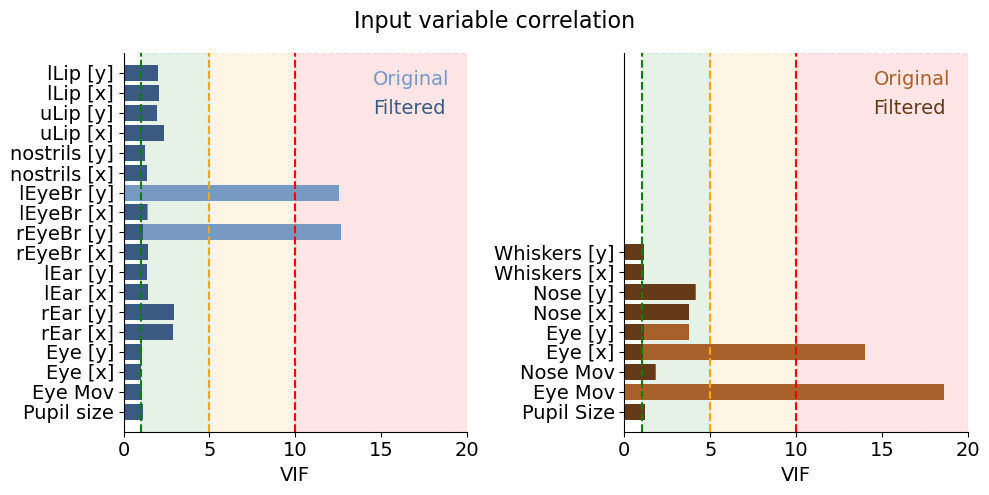

In [83]:
import pandas as pd
import statsmodels.api as sm

def calculate_vif(input_data, col_names):

    if not isinstance(input_data, pd.DataFrame):
        input_data = pd.DataFrame(input_data)
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = col_names
    
    # Calculate VIF for each feature
    vif_data["VIF"] = [1 / (1 - sm.OLS(input_data[col].values, 
                                       sm.add_constant(input_data.loc[:, input_data.columns != col].values)).fit().rsquared) for col in input_data.columns]

    return vif_data

varNames_macaque = np.array(['Pupil size', 'Eye Mov', 'Eye [x]', 'Eye [y]', 'rEar [x]', 'rEar [y]', 'lEar [x]', 'lEar [y]', 
            'rEyeBr [x]', 'rEyeBr [y]', 'lEyeBr [x]', 'lEyeBr [y]', 'nostrils [x]', 'nostrils [y]', 
            'uLip [x]', 'uLip [y]', 'lLip [x]', 'lLip [y]'])
varNames_mouse = np.array(['Pupil Size', 'Eye Mov', 'Nose Mov', 'Eye [x]', 'Eye [y]', 'Nose [x]', 'Nose [y]', 'Whiskers [x]', 'Whiskers [y]'])

dats_train_mouse = np.load('Predictors_emissions_mouse_concat_train_20pad.npz', allow_pickle = True)
dat_mouse = dats_train_mouse['predictors']
dats_train_macaque = np.load('Predictors_emissions_macaque_concat_train_10pad.npz', allow_pickle = True)
dat_macaque = dats_train_macaque['predictors']


vif_mouse = calculate_vif(dat_mouse, varNames_mouse)
vif_mouse_filtered = calculate_vif(dat_mouse[:,varNames_mouse!='Eye Mov'], varNames_mouse[varNames_mouse!='Eye Mov'])
vif_macaque = calculate_vif(dat_macaque, varNames_macaque)
vif_macaque_filtered = calculate_vif(dat_macaque[:,varNames_macaque!='lEyeBr [y]'], varNames_macaque[varNames_macaque!='lEyeBr [y]'])

# Function to align and merge VIF data
def align_and_merge_vif(vif_main, vif_filtered, features_main):
    vif_all = pd.DataFrame({'feature': features_main, 'VIF_main': np.nan, 'VIF_filtered': np.nan})
    vif_all = vif_all.set_index('feature')
    vif_all.loc[vif_main['feature'], 'VIF_main'] = vif_main['VIF'].values
    vif_all.loc[vif_filtered['feature'], 'VIF_filtered'] = vif_filtered['VIF'].values

    return vif_all.reset_index()

# Align and merge VIF data
vif_mouse_all = align_and_merge_vif(vif_mouse, vif_mouse_filtered, varNames_mouse)
vif_macaque_all = align_and_merge_vif(vif_macaque, vif_macaque_filtered, varNames_macaque)

# Plotting
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
colors = ['#7899c2ff', '#A8612A']
cus_pal = sns.color_palette(['#7899c2ff', '#A8612A'])

# Mouse
ax[0].barh(vif_macaque_all['feature'], vif_macaque_all['VIF_main'], color=colors[0], label='Original')
ax[0].barh(vif_macaque_all['feature'], vif_macaque_all['VIF_filtered'], color=darken_color(colors[0],0.6), label='Filtered')

# Macaque
ax[1].barh(vif_mouse_all['feature'], vif_mouse_all['VIF_main'], color=colors[1], label='Original')
ax[1].barh(vif_mouse_all['feature'], vif_mouse_all['VIF_filtered'], color=darken_color(colors[1],0.6), label='Filtered')
ax[1].set_ylim(-1, len(vif_macaque_all['feature']))
ax[0].set_ylim(-1, len(vif_macaque_all['feature']))
# Shared formatting
for axi in ax:
    axi.axvline(1, ls='--', color='green')
    axi.axvspan(xmin = 1, xmax = 5, ls='--', color='green', alpha = 0.1, zorder = -1)
    axi.axvspan(xmin = 5, xmax = 10, ls='--', color='orange', alpha = 0.1, zorder = -1)
    axi.axvspan(xmin = 10, xmax = 20, ls='--', color='red', alpha = 0.1, zorder = -1)
    axi.axvline(5, ls='--', color='orange')
    axi.axvline(10, ls='--', color='red')
    axi.set_xlabel('VIF', fontsize=14)
    axi.set_xlim(0, 20)
    axi.legend(frameon = False, handlelength = 0, labelcolor = 'linecolor', fontsize = 14)
    axi.set_xticks(np.linspace(0, 20, 5), np.linspace(0, 20, 5).astype(int), fontsize = 14)
    axi.set_yticks(axi.get_yticks(), axi.get_yticklabels(), fontsize = 14)
sns.despine()
plt.suptitle('Input variable correlation', fontsize = 16)
plt.tight_layout()
plt.savefig('BothSpecies_VariableCorrelation_23112023.pdf', transparent = True)

## Matched Models

In [ ]:
import glob
import numpy as np
from natsort import natsorted
import seaborn as sns
import matplotlib.pyplot as plt
import matplotx as mpx


files_results_macaque_full = natsorted(glob.glob('Results/Macaque/Results_CV_sLDS_Optuna_macaque_100trials_*_states_28112023_RT_noLEyeBrModel_AllSubjects_R2score_CVOnly.npz', recursive = True))
cv_scores_macaque_full = np.zeros((len(files_results_macaque_full), 100))

for ii, file in enumerate(files_results_macaque_full):
    a = np.load(file, allow_pickle = True)
    cv_scores_macaque_full[ii, :] =  a[a.files[0]][()].copy()

files_results_mouse_full = natsorted(glob.glob('Results/Mouse/Results_CV_sLDS_Optuna_mouse_100trials_*_states_28112023_RT_noEyeMovModel_AllSubjects_R2score_CVOnly.npz', recursive = True))
cv_scores_mouse_full = np.zeros((len(files_results_mouse_full), 100))
for ii, file in enumerate(files_results_mouse_full):
    a = np.load(file, allow_pickle = True)
    keyss = list(a.keys())
    cv_scores_mouse_full[ii, :] =  a[a.files[0]][()].copy()
cv_scores_mouse_full[cv_scores_mouse_full<-100] = 0


files_results_macaque_matched = natsorted(glob.glob('Results/Macaque/Results_CV_MSLR_Optuna_macaque_50trials_*_states_12122023_RT_FeatureMatching_AllSubjects_R2score_CVOnly.npz', recursive = True))
cv_scores_macaque_matched = np.zeros((len(files_results_macaque_matched), 50))
for ii, file in enumerate(files_results_macaque_matched):
    a = np.load(file, allow_pickle = True)
    cv_scores_macaque_matched[ii, :] =  a[a.files[0]][()].copy()

files_results_mouse_matched = natsorted(glob.glob('Results/Mouse/Results_CV_MSLR_Optuna_mouse_50trials_*_states_12122023_RT_TwoAnimals_R2score_CVOnly.npz', recursive = True))
cv_scores_mouse_matched = np.zeros((len(files_results_mouse_matched), 50))
for ii, file in enumerate(files_results_mouse_matched):
    a = np.load(file, allow_pickle = True)
    keyss = list(a.keys())
    cv_scores_mouse_matched[ii, :] =  a[a.files[0]][()].copy()

import pandas as pd
import seaborn as sns
import BehavUtils as butils


two_mice_data = np.load('RawData/Mouse/Predictors_emissions_mouse_TwoAnimals_concat_train_20pad.npz', allow_pickle = True)
dat_train_twomice = two_mice_data['predictors']

dats_train = np.load('Predictors_emissions_macaque_concat_train_10pad.npz', allow_pickle = True)
dat_train_final = dats_train['predictors'] 
y_train_final = dats_train['emissions'] 
selected_trials = np.sort(np.random.choice(np.arange(dat_train_final.shape[0]), size = dat_train_twomice.shape[0], replace = False))
dat_train_final = dat_train_final[selected_trials,:]   
y_train_final = y_train_final[selected_trials,:]   
varNames = np.array(['PupSize', 'EyeMov', 'Eye_x', 'Eye_y', 'rEar_x', 'rEar_y', 'lEar_x', 'lEar_y', 
            'rEyeBr_x', 'rEyeBr_y', 'lEyeBr_x', 'lEyeBr_y', 'nostrils_x', 'nostrils_y', 
            'uLip_x', 'uLip_y', 'lLip_x', 'lLip_y'])
lips_x = (dat_train_final[:,np.where(varNames=='uLip_x')[0]] + dat_train_final[:,np.where(varNames=='lLip_x')[0]])/2
lips_y = (dat_train_final[:,np.where(varNames=='uLip_y')[0]] + dat_train_final[:,np.where(varNames=='lLip_y')[0]])/2
lips_x = lips_x.reshape(-1,)
lips_y = lips_y.reshape(-1,)

nostrilMov = np.sqrt(np.power(dat_train_final[:,np.where(varNames=='nostrils_x')[0]],2) + np.power(dat_train_final[:,np.where(varNames=='nostrils_y')[0]],2))
nostrilMov = nostrilMov.reshape(-1,)
predictors_smaller = np.column_stack([dat_train_final[:,:4],nostrilMov,dat_train_final[:,[12,13]],lips_x,lips_y])
varNames_smaller = np.array(['PupSize', 'EyeMov', 'Eye_x', 'Eye_y', 'NostrilMov', 'nostrils_x', 'nostrils_y', 'Lip_x', 'Lip_y'])
np.savez('RawData/Macaque/Predictors_emissions_macaque_FeatureMatching_concat_train_10pad.npz', predictors = predictors_smaller, emissions = y_train_final)
fig, ax = plt.subplots(figsize = (5, 4))
meds_macaque = np.nanmax(cv_scores_macaque_matched,axis = 1)
meds_mouse = np.nanmax(cv_scores_mouse_matched,axis = 1)

# Calculate standard deviations
std_low_macaque = np.nanpercentile(cv_scores_macaque_matched, 5, axis=1)
std_low_mouse = np.nanpercentile(cv_scores_mouse_matched, 5, axis=1)

meds = [meds_macaque, meds_mouse]
std_low = [std_low_macaque, std_low_mouse]
# Plot medians and stds
for ii in range(2):
    x = np.arange(meds[ii].shape[0])+2
    ax.plot(x, meds[ii], color=darken_color(colors[ii], 0.7), mfc=colors[ii], ms=8, mew=1, marker = ['o', '^'][ii])
    ax.fill_between(x, std_low[ii], meds[ii], color=colors[ii], alpha = 0.5)
ax.set_ylim([0, 1])
ax.set_ylabel('$R^2$ (Cross-Val)', fontsize=16)
ax.set_xlabel('# internal states', fontsize=16)

ax.set_ylim(-1, 1)
ax.set_xlim(1, 15.5)
xtiks = np.arange(2, cv_scores_macaque_full.shape[0] + 2)[::2]
ax.set_xticks(xtiks)
ax.set_yticks(np.linspace(-1,1,5), np.linspace(-1,1,5))
ax.set_xticklabels(np.arange(2, cv_scores_macaque_full.shape[0] + 2)[::2], fontsize=14)
plt.savefig('Results/BothSpecies_MatchedModelsOnly_numStates_R2_CV_RT_15122023.svg', transparent = True)
import glob
import numpy as np
from natsort import natsorted
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error as mse
from scipy.stats import mannwhitneyu as mu
import BehavUtils as butils
import cmcrameri as cmc

selected_variables_mouse = ['PupilSize', 'EyeMov', 'NoseMov', 'Eye [x]', 'Eye [y]', 'Nose [x]', 'Nose [y]', 'Whiskers [x]', 'Whiskers [y]']
varNames_smaller_macaque = np.array(['PupSize', 'EyeMov', 'Eye_x', 'Eye_y', 'NostrilMov', 'nostrils_x', 'nostrils_y', 'Lip_x', 'Lip_y'])

newOrder_mouse = np.array([0, 1, 3, 4, 2, 5, 6, 7, 8])
newOrder_macaque = np.array([0,1,2,3,8,9,10,11, 12, 13, 14, 15, 16, 17, 4,  5,  6,  7])

cols_macaque = sns.color_palette(["#52ef99", "#146c45", "#778DF9", '#40C7B0', "#aae3a4", '#2A7958', "#21638f", '#516578', "#3aa609", '#4B8AC7', '#2D4EF7'])
cols_mouse = sns.color_palette(["#5a3386", '#FF8C80', "#8c75d2", '#FBA984', "#940393", '#FE9E47', "#e9b7e3", "#cf60f3", "#ff66b2", sns.desaturate("#ff66b2", 0.5), '#FF8C80'])

#stat_labs = [np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G']), np.array(['A', 'B', 'C', 'D', 'E', 'F'])]
stat_labs = [np.array(['A', 'B', 'C', 'D']), np.array(['A', 'B', 'C'])]

numTrials = 100
date = '12122023'

files_results_macaque = natsorted(glob.glob('Results/Macaque/*'+str(numTrials)+'trials_'+date+'_RT_FeatureMatching_AllSubjects_session*.npz', recursive = True))
files_results_mouse = natsorted(glob.glob('Results/Mouse/*'+str(numTrials)+'trials_'+date+'_RT_TwoAnimals_session*.npz', recursive = True))

with open('RawData/Macaque/files_logs_macaque_moreSes.txt') as f:
    files_logs_macaque = [line.strip() for line in f.readlines()]
    
with open('RawData/Mouse/files_logs_mouse_moreSes.txt') as f:
    files_logs_mouse = [line.strip() for line in f.readlines()]

subjects_macaque = ['Cosmos', 'Karl']
stickiness_macaque, concentration_macaque, predictions_macaque, X_test_macaque, y_test_macaque, numStates_macaque, predicted_states_macaque, predicted_statesProbs_macaque, transitionMatrices_macaque, weights_macaque, errorTrials_macaque = [], [], [], [], [], [], [], [], [], [], []
cv_scores_macaque = []
for file in files_results_macaque:
    a = np.load(file, allow_pickle = True)

    X_test_macaque.append(a[a.files[0]][()]['X_test'])
    y_test_macaque.append(a[a.files[0]][()]['y_test'])
    predictions_macaque.append(a[a.files[0]][()]['predictions'])
    numStates_macaque.append(a[a.files[0]][()]['numStates'])
    concentration_macaque.append(a[a.files[0]][()]['concentration'])
    stickiness_macaque.append(a[a.files[0]][()]['stickiness'])
    predicted_states_macaque.append(a[a.files[0]][()]['predicted_states'])
    predicted_statesProbs_macaque.append(a[a.files[0]][()]['predicted_statesProbs'])
    transitionMatrices_macaque.append(a[a.files[0]][()]['transitionMatrices'])
    weights_macaque.append(a[a.files[0]][()]['weights'])

numShuff = 100
perf_macaque_matched = np.full(len(y_test_macaque), np.nan)

for i in range(len(y_test_macaque)):
    preds = np.array(predictions_macaque[i])
    preds[preds<0] = 0
    perf_macaque_matched[i] = r2_score(y_test_macaque[i], preds)

with open('RawData/Mouse/files_logs_mouse_moreSes.txt') as f:
    files_logs_mouse = [line.strip() for line in f.readlines()]
    
subjects_mouse = ['001', '003', '004', '005', '012', '013']
stickiness_mouse, concentration_mouse, predictions_mouse, X_test_mouse, y_test_mouse, numStates_mouse, predicted_states_mouse, predicted_statesProbs_mouse, transitionMatrices_mouse, weights_mouse, errorTrials_mouse = [], [], [], [], [], [], [], [], [], [], []
cv_scores_mouse = []
for file in files_results_mouse:
    a = np.load(file, allow_pickle = True)

    X_test_mouse.append(a[a.files[0]][()]['X_test'])
    y_test_mouse.append(a[a.files[0]][()]['y_test'])
    predictions_mouse.append(a[a.files[0]][()]['predictions'])
    numStates_mouse.append(a[a.files[0]][()]['numStates'])
    concentration_mouse.append(a[a.files[0]][()]['concentration'])
    stickiness_mouse.append(a[a.files[0]][()]['stickiness'])
    predicted_states_mouse.append(a[a.files[0]][()]['predicted_states'])
    predicted_statesProbs_mouse.append(a[a.files[0]][()]['predicted_statesProbs'])
    transitionMatrices_mouse.append(a[a.files[0]][()]['transitionMatrices'])
    weights_mouse.append(a[a.files[0]][()]['weights'])

perf_mouse_matched = np.full(len(y_test_mouse), np.nan)

for i in range(len(y_test_mouse)):
    preds = np.array(predictions_mouse[i])
    preds[preds<0] = 0
    perf_mouse_matched[i] = r2_score(y_test_mouse[i], preds)

fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))
num_states_macaque = transitionMatrices_macaque[0].shape[0]
num_states_mouse = transitionMatrices_mouse[0].shape[0]
mask = np.array(transitionMatrices_macaque[0]) < 0.1
#hm1 = sns.heatmap(transitionMatrices_macaque[0], mask = mask, vmin = 0, vmax = 1, cbar = True, ax = ax[0],
#        cmap = 'cmc.oslo_r', cbar_kws = {'label':'Transition probability'}, annot = True, fmt = '.2g', annot_kws={'fontsize':12}, linewidth = 1, linecolor = 'black')
hm1 = sns.heatmap(transitionMatrices_macaque[0], vmin = 0, vmax = 1, cbar = True, ax = ax[0],
        cmap = 'cmc.oslo_r', cbar_kws = {'label':'Transition probability'}, annot = False, fmt = '.2g', annot_kws={'fontsize':14}, linewidth = 1, linecolor = 'black')
hm1.figure.axes[-1].yaxis.label.set_size(18)
cbar = ax[0].collections[0].colorbar
# here set the labelsize b
cbar.ax.tick_params(labelsize=15)
mask = np.array(transitionMatrices_mouse[0]) < 0.1


hm2 = sns.heatmap(transitionMatrices_mouse[0], vmin = 0, vmax = 1, cbar = True, ax = ax[1],
        cmap = 'cmc.lajolla', cbar_kws = {'label':'Transition probability'}, annot = False, fmt = '.2g', annot_kws={'fontsize':14}, linewidth = 1, linecolor = 'black')

hm2.figure.axes[-1].yaxis.label.set_size(18)
cbar = ax[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
for axi in ax:
    axi.set_ylabel('State', fontsize = 16)
    axi.set_xlabel('State', fontsize = 16)
ax[0].set_yticks(ticks = np.arange(num_states_macaque)+0.5, labels = stat_labs[0], fontsize = 16, rotation = 0)
ax[0].set_xticks(ticks = np.arange(num_states_macaque)+0.5, labels = stat_labs[0], fontsize = 16)
ax[1].set_yticks(ticks = np.arange(num_states_mouse)+0.5, labels = stat_labs[1], fontsize = 16, rotation = 0)
ax[1].set_xticks(ticks = np.arange(num_states_mouse)+0.5, labels = stat_labs[1], fontsize = 16)
plt.tight_layout()
plt.savefig('Results/BothSpecies_TransitionMatrices_MatchedModels_Test_RT_15122023.svg', transparent = True)

## Cross-mice generalization

In [ ]:
# Import necessary libraries
import numpy as np
import seaborn as sns
import optuna
from optuna.trial import TrialState
from parse_logfile import TextLog
import pipeline_MSLR as pipln
import pandas as pd
import seaborn as sns
import warnings
import BehavUtils as butils
import glob
from natsort import natsorted
import time
import reaction_time as reac
from jax.config import config
import os
import acme
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# Enable 64-bit precision in JAX
config.update("jax_enable_x64", True)

# Set seaborn plot style and ignore warnings
sns.set_style('white')
warnings.filterwarnings(action='ignore', message='Mean of empty slice')
warnings.filterwarnings(action='ignore', message='Degrees of freedom <= 0 for slice')
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')
warnings.filterwarnings(action='ignore', message='RuntimeWarning: invalid value encountered in double_scalars')
np.seterr(over='ignore')

# Define the animal
animal = 'mouse'

# Load log, flash, face, and eye files
with open('RawData/Mouse/files_logs_mouse_moreSes.txt') as f:
    files_logs = [line.strip() for line in f.readlines()]
with open('RawData/Mouse/files_flashes_mouse_moreSes.txt') as f:
    files_flashes = [line.strip() for line in f.readlines()]
with open('RawData/Mouse/files_face_mouse_moreSes_updated.txt') as f:
    files_face = [line.strip() for line in f.readlines()]
with open('RawData/Mouse/files_eye_mouse_moreSes_updated.txt') as f:
    files_eye = [line.strip() for line in f.readlines()]

# Define which column names to read from the face and eye files
with open('RawData/Mouse/cols_nose_updated.txt') as f:
    cols_nose = [line.strip() for line in f.readlines()]
with open('RawData/Mouse/cols_whiskers_updated.txt') as f:
    cols_whiskers = [line.strip() for line in f.readlines()]
with open('RawData/Mouse/cols_eye.txt') as f:
    cols_eye = [line.strip() for line in f.readlines()]

# Define parameters for cross-validation, repetitions, and data splitting
nWindows = 5
nRepetitions = 5
nSplits = 5
btscv = butils.BlockingTimeSeriesSplit(n_splits=nSplits)
shiftStim = -0.25
winSize = 0.25
internal_states = np.arange(2, 16)

# Define how many partitions to use for Dask loading in the data.
nPartitions = os.cpu_count() - 2

# Clean up the cluster and set up a new cluster client
acme.cluster_cleanup()
client = acme.esi_cluster_setup(partition="8GBXS", n_jobs=int(nSplits),
                                n_jobs_startup=2, timeout=60000, interactive_wait=1)

start1 = time.time()

# Define session indices for each mouse
mouse_1 = np.array([15,16,17,18,19,20,21,22,23,24,25,26])
mouse_2 = np.array([0,1,2,3])
mouse_3 = np.array([4,5,6,7,27,28])
mouse_4 = np.array([8,9,10])
mouse_5 = np.array([11,12])
mouse_6 = np.setdiff1d(np.arange(len(files_logs)), np.concatenate([mouse_1, mouse_2, mouse_3, mouse_4, mouse_5]))

# Organize mouse sessions into a dictionary for easy access
mouse_sessions = {
    'mouse_1': mouse_1,
    'mouse_2': mouse_2,
    'mouse_3': mouse_3,
    'mouse_4': mouse_4,
    'mouse_5': mouse_5,
    'mouse_6': mouse_6
}

# Initialize dictionaries to store training and testing data for each mouse
mouse_data = {
    mouse: {
        'dat_train_list': [],
        'dat_test_list': [],
        'y_train_list': [],
        'y_test_list': []
    } for mouse in mouse_sessions
}

# Function to determine which mouse a session belongs to
def get_mouse_label(session_idx):
    for mouse_label, sessions in mouse_sessions.items():
        if session_idx in sessions:
            return mouse_label
    return None  # In case a session doesn't belong to any mouse

# Iterate over all sessions
for rr in range(len(files_logs)):

    # Determine which mouse this session belongs to
    mouse_label = get_mouse_label(rr)
    if mouse_label is None:
        print(f"Session {rr} does not belong to any defined mouse. Skipping.")
        continue  # Skip sessions that don't belong to any mouse

    # Load flashes data
    flashes = np.load(files_flashes[rr], allow_pickle=True)

    # Parse event markers from log file
    evt, newSamp, nPoints, t_final, idx_start, idx_stim, _ = butils.readLog(files_logs[rr], 'mouse')

    # Process session data, reaction times, and rescale reaction times
    sess_data = reac.sess_data_maker(files_logs[rr], animal, 3000)
    r_time, _ = reac.reaction_time(sess_data, [5,10,15])
    r_time[pd.isna(r_time)] = -1
    r_time = r_time.astype(np.float64)
    r_time = r_time / newSamp
    r_time[r_time > 4] = 4

    t_tmp = np.nan * np.ones(nPoints)
    t_tmp[idx_start[:-1]] = flashes[:-1]
    frames_dlc = pd.Series(t_tmp).interpolate(method="linear").values
    frames_dlc[np.isnan(frames_dlc)] = 0
    frames_dlc = np.array(frames_dlc, dtype=int)

    t_stim = np.unique(t_final[idx_stim])

    # Load facial and eye data using Dask
    dat_face = butils.daskLoadCSV(files_face[rr], cols_nose, nPartitions=nPartitions)
    dat_whis = butils.daskLoadCSV(files_face[rr], cols_whiskers, nPartitions=nPartitions)
    dat_eye = butils.daskLoadCSV(files_eye[rr], cols_eye, nPartitions=nPartitions)

    # Calculate positions and sizes
    nose_x_fin, nose_y_fin, _ = butils.dlcCalcs(dat_face, nPoints=frames_dlc.shape[0], doSize=0)
    eye_x_fin, eye_y_fin, pupSize_t = butils.dlcCalcs(dat_eye, nPoints=frames_dlc.shape[0], doSize=1)
    whisk_x_fin, whisk_y_fin, _ = butils.dlcCalcs(dat_whis, nPoints=frames_dlc.shape[0], doSize=0)

    # Prepare predictors
    predVar = [eye_x_fin, eye_y_fin, nose_x_fin, nose_y_fin, whisk_x_fin, whisk_y_fin]
    predictors = butils.preprocess_data(predVar, pupSize_t, eye_x_fin, eye_y_fin, t_final, idx_start, t_stim, animal, shiftStim, winSize)

    # Ensure predictors and reaction times have the same length
    if predictors.shape[0] > r_time.shape[0]:
        predictors = predictors[:-1,:]
    elif predictors.shape[0] < r_time.shape[0]:
        r_time = r_time[:-1]

    # Split data into training and testing sets
    size = int(len(r_time) * 0.8)
    dat_train, dat_test, y_train, y_test = predictors[:size,:], predictors[size:,:], r_time[:size], r_time[size:]
    estimator = BayesianRidge()

    # Impute missing values in training data
    imp = IterativeImputer(estimator=estimator, random_state=42, max_iter=100, sample_posterior=True, skip_complete=True)
    dat_train = imp.fit_transform(dat_train)
    y_train = y_train.reshape(-1,1)

    # Append the processed data to the corresponding mouse's lists
    mouse_data[mouse_label]['dat_train_list'].append(dat_train)
    mouse_data[mouse_label]['dat_test_list'].append(dat_test)
    mouse_data[mouse_label]['y_train_list'].append(y_train)
    mouse_data[mouse_label]['y_test_list'].append(y_test)

# After processing all sessions, concatenate data separately for each mouse
dat_train_final = {}
dat_test_final = {}
y_train_final = {}
y_test_final = {}

for mouse_label, data in mouse_data.items():
    # Concatenate training and testing data
    dat_train_final[mouse_label] = butils.pad_concatenate(data['dat_train_list'], doEmissions=False, numPad=20)
    y_train_final[mouse_label] = butils.pad_concatenate(data['y_train_list'], doEmissions=True, numPad=20)

# ================================
# ======= Saving the Data ========
# ================================

# Define the directory to save the processed data
save_dir = 'RawData/Mouse/'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the concatenated training data per mouse
train_save_path = os.path.join(save_dir, 'Predictors_emissions_train_per_mouse_generalisation_20pad.npz')
np.savez(
    train_save_path,
    dat_train_final=dat_train_final,
    y_train_final=y_train_final
)
print(f"Training data per mouse saved to {train_save_path}")
end1 = time.time()
print(f"Data processing and saving completed in {np.round(end1 - start1, 2)} seconds.")


<ParallelMap> WARNING: <cluster_cleanup> No dangling clients or clusters found.


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39957 instead
  warnings.warn(
<ParallelMap> INFO: <slurm_cluster_setup> Requested job-count 5 exceeds `n_jobs_startup`: waiting for 2 jobs to come online, then proceed
INFO:<ParallelMap>:<slurm_cluster_setup> Requested job-count 5 exceeds `n_jobs_startup`: waiting for 2 jobs to come online, then proceed
<slurm_cluster_setup> SLURM workers ready: 5/None 	[elapsed time 00:11 | timeout at :40:00]
<ParallelMap> INFO: <slurm_cluster_setup> Cluster dashboard accessible at http://10.100.32.3:39957/status
INFO:<ParallelMap>:<slurm_cluster_setup> Cluster dashboard accessible at http://10.100.32.3:39957/status


N frames missed: 22
GFrameNumber does not match first PresentCount, automatically adjusting
AnimalCharacter_C_2147482442
N frames missed: 22
GFrameNumber does not match first PresentCount, automatically adjusting


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 34
AnimalCharacter_C_2147482442
N frames missed: 34


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 20
AnimalCharacter_C_2147482442
N frames missed: 20


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 23
AnimalCharacter_C_2147482442
N frames missed: 23


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 25
AnimalCharacter_C_2147482442
N frames missed: 25


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 43
AnimalCharacter_C_2147482442
N frames missed: 43


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 24
AnimalCharacter_C_2147482442
N frames missed: 24


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 23
AnimalCharacter_C_2147482443
N frames missed: 23


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 10
AnimalCharacter_C_2147482442
N frames missed: 10


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 14
AnimalCharacter_C_2147482442
N frames missed: 14


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 2
AnimalCharacter_C_2147482442
N frames missed: 2


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 13
AnimalCharacter_C_2147482443
N frames missed: 13


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 24
AnimalCharacter_C_2147482442
N frames missed: 24


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 5
AnimalCharacter_C_2147482442
N frames missed: 5


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 11
AnimalCharacter_C_2147482442
N frames missed: 11


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 10
AnimalCharacter_C_2147482443
N frames missed: 10


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 12
AnimalCharacter_C_2147482442
N frames missed: 12


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 8
AnimalCharacter_C_2147482442
N frames missed: 8


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 15
AnimalCharacter_C_2147482443
N frames missed: 15


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 26
GFrameNumber does not match first PresentCount, automatically adjusting
AnimalCharacter_C_2147482443
N frames missed: 26
GFrameNumber does not match first PresentCount, automatically adjusting


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 16
AnimalCharacter_C_2147482443
N frames missed: 16


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 19
AnimalCharacter_C_2147482442
N frames missed: 19


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 32
AnimalCharacter_C_2147482440
N frames missed: 32


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 14
AnimalCharacter_C_2147482440
N frames missed: 14


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 6
AnimalCharacter_C_2147482443
N frames missed: 6


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 20
AnimalCharacter_C_2147482443
N frames missed: 20


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 14
AnimalCharacter_C_2147482442
N frames missed: 14


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 23
AnimalCharacter_C_2147482443
N frames missed: 23


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

N frames missed: 24
AnimalCharacter_C_2147482442
N frames missed: 24


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:35387' processes=5 threads=5, memory=37.25 GiB>
<ParallelMap> INFO: Preparing 6 parallel calls of `medianPos` using 5 workers
INFO:<ParallelMap>:Preparing 6 parallel calls of `medianPos` using 5 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241114-170858
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaiebor

Training data per mouse saved to RawData/Mouse/Predictors_emissions_train_per_mouse_generalisation_20pad.npz
Data processing and saving completed in 948.85 seconds.


In [ ]:
# Import necessary libraries
import numpy as np
import optuna
import pipeline_MSLR as pipln
import warnings
import BehavUtils as butils
import time
from jax.config import config
import os
import acme
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score  # For computing R² scores
from collections import defaultdict  # For aggregating R² scores

# Enable 64-bit precision in JAX
config.update("jax_enable_x64", True)

# Ignore specific warnings to keep the output clean
warnings.filterwarnings(action='ignore', message='Mean of empty slice')
warnings.filterwarnings(action='ignore', message='Degrees of freedom <= 0 for slice')
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')
warnings.filterwarnings(action='ignore', message='RuntimeWarning: invalid value encountered in double_scalars')
np.seterr(over='ignore')

# Define the animal type
animal = 'mouse'

date = '14112024'

# Load log, flash, face, and eye files
with open('RawData/Mouse/files_logs_mouse_moreSes.txt') as f:
    files_logs = [line.strip() for line in f.readlines()]

# Define parameters for cross-validation, repetitions, and data splitting
nWindows = 5
nRepetitions = 5
nSplits = 5
btscv = butils.BlockingTimeSeriesSplit(n_splits=nSplits)
shiftStim = -0.25
winSize = 0.25
internal_states = np.arange(2, 16)  # Range of internal states to evaluate

# Define how many partitions to use for Dask loading in the data
nPartitions = os.cpu_count() - 2

# Number of trials Optuna will perform for hyperparameter optimization
numTrials = 50

# Clean up the cluster and set up a new cluster client
acme.cluster_cleanup()
client = acme.esi_cluster_setup(partition="8GBXS", n_jobs=int(nSplits),
                                n_jobs_startup=2, timeout=60000, interactive_wait=1)

# Start overall timing
start1 = time.time()

# Define session indices for each mouse
mouse_1 = np.array([15,16,17,18,19,20,21,22,23,24,25,26])
mouse_2 = np.array([0,1,2,3])
mouse_3 = np.array([4,5,6,7,27,28])
mouse_4 = np.array([8,9,10])
mouse_5 = np.array([11,12])
mouse_6 = np.setdiff1d(np.arange(len(files_logs)), 
                        np.concatenate([mouse_1, mouse_2, mouse_3, mouse_4, mouse_5]))

# Organize mouse sessions into a dictionary for easy access
mouse_sessions = {
    'mouse_1': mouse_1,
    'mouse_2': mouse_2,
    'mouse_3': mouse_3,
    'mouse_4': mouse_4,
    'mouse_5': mouse_5,
    'mouse_6': mouse_6
}

# List of mouse labels for iteration
mouse_labels = list(mouse_sessions.keys())

variables_mouse = np.array(['Pupil Size', 'Eye Mov', 'Nose Mov', 'Eye [x]', 'Eye [y]', 'Nose [x]', 'Nose [y]', 'Whiskers [x]', 'Whiskers [y]'])

# ================================
# ======= Loading Training Data ===
# ================================

# Load pre-concatenated training data per mouse
train_test_dir = 'RawData/Mouse/'  # Directory where processed data is saved
train_data_path = os.path.join(train_test_dir, 'Predictors_emissions_train_per_mouse_generalisation_20pad.npz')

# Verify that the training data file exists
if not os.path.exists(train_data_path):
    raise FileNotFoundError(f"Training data file not found at {train_data_path}")

# Load the training data
dat_all_train = np.load(train_data_path, allow_pickle=True)
dat_train_final = dat_all_train['dat_train_final'].item()  # Dictionary: { 'mouse_1': array, ... }
y_train_final = dat_all_train['y_train_final'].item()      # Dictionary: { 'mouse_1': array, ... }

# Clamp y_train_final to a maximum value of 4
for mouse_label in y_train_final:
    y_train_final[mouse_label] = np.clip(y_train_final[mouse_label], None, 4)

# Remove 'Eye Mov' from dat_train_final
eye_mov_idx = np.where(variables_mouse != 'Eye Mov')[0]
for mouse_label in dat_train_final:
    dat_train_final[mouse_label] = dat_train_final[mouse_label][:, eye_mov_idx]

# ================================
# ======= Loading Optuna Results ===
# ================================

# Load Optuna results (ensure this file exists and contains the necessary data)
optuna_results_path = 'Results/Mouse/Results_CV_sLDS_Optuna_mouse_100trials_3_states_28112023_RT_noEyeMovModel_AllSubjects_R2score_CVOnly.npz'
if not os.path.exists(optuna_results_path):
    raise FileNotFoundError(f"Optuna results file not found at {optuna_results_path}")

dat_optuna = np.load(optuna_results_path, allow_pickle=True)
# Extract selected concentration and stickiness
selected_concentration = dat_optuna['concentration']
selected_stickiness = dat_optuna['stickiness']

# ================================
# ======= LOO-CV Loop ============
# ================================

# Initialize a dictionary to collect R² scores per internal state
r2_scores_per_state = defaultdict(list)

# Iterate over each leave-one-mouse-out fold
for held_out_mouse in mouse_labels:
    start_fold = time.time()
    print(f'\nProcessing fold: Training on all mice except {held_out_mouse}, testing on {held_out_mouse}')
    
    # Prepare training data by concatenating data from all mice except the held-out mouse
    train_dat_list = [dat_train_final[mouse] for mouse in mouse_labels if mouse != held_out_mouse]
    train_y_list = [y_train_final[mouse] for mouse in mouse_labels if mouse != held_out_mouse]
    
    # Concatenate training data and labels
    train_dat = np.concatenate(train_dat_list, axis=0)
    train_y = np.concatenate(train_y_list, axis=0).reshape(-1, 1)
    
    # Retrieve the test session indices for the held-out mouse
    test_session_indices = mouse_sessions[held_out_mouse]
    
    # Iterate through each test session individually
    for session_idx, rr in enumerate(test_session_indices):
        print(f'  Testing on session {session_idx+1} of {held_out_mouse}')
        
        # Define the test filename based on the session index
        test_filename = f'RawData/Mouse/Predictors_emissions_mouse_newDLC_test_session{rr}_nonScaled.npz'
        
        # Check if the test file exists
        if not os.path.exists(test_filename):
            print(f"    Test file {test_filename} not found. Skipping session {rr}.")
            continue  # Skip if test file does not exist
        
        # Load test session data
        dats = np.load(test_filename, allow_pickle=True)
        dat_test = dats['predictors']
        dat_test = dat_test[:, eye_mov_idx]
        
        y_test = dats['emissions']
        y_test = np.clip(y_test, None, 4)  # Clamp emissions to a maximum of 4
        
        # Iterate over each selected internal state
        for selected_states in [3]:#internal_states:
            start2 = time.time()
            # print(f'    Training with selected_states={selected_states}')
            
            try:
                # Initialize the MSLR model instance
                mouse_MSLR_instance = pipln.model_MSLR_concat(
                    train_y,               # Training emissions
                    train_dat,             # Training predictors
                    y_test,                # Testing emissions for the current session
                    dat_test,              # Testing predictors for the current session
                    selected_states, 
                    selected_concentration, 
                    selected_stickiness,
                    btscv,
                    nRepetitions
                )
                pipln.model_MSLR_concat(y_train_final,dat_train_final,y_test,dat_test,
                                                           selected_states, selected_concentration, selected_stickiness,btscv,nRepetitions)

                # Perform testing
                _, y_pred, y_test_out, state_probabilities, most_likely_states, _, _ = mouse_MSLR_instance.test_mslr()
                
                # Compute R² score
                r2 = r2_score(y_test_out, y_pred)
                
                # Append the R² score to the corresponding internal state
                r2_scores_per_state[selected_states].append(r2)
                
                # Prepare results dictionary (optional: save more details if needed)
                results = {
                    'predictions': y_pred,
                    'y_test': y_test_out,
                    'R2_score': r2,
                    'state_probabilities': state_probabilities,
                    'most_likely_states': most_likely_states
                }
                
                # Define the result filename
                result_filename = (
                    f"Results/Mouse/Results_Test_MSLR_Optuna_mouse_{selected_states}states_leave_one_out_"
                    f"{date}_RT_AllSubjects_{held_out_mouse}_session{session_idx+1}.npz"
                )
                
                # Ensure the results directory exists
                os.makedirs(os.path.dirname(result_filename), exist_ok=True)
                
                # Save the results
                np.savez(result_filename, results)
                
                print(f'      Session {session_idx+1}, selected_states={selected_states} completed in '
                      f'{np.round(time.time() - start2, 2)} seconds. R²: {r2:.4f}')
            
            except Exception as e:
                print(f"      Error processing session {session_idx+1}, state {selected_states}: {e}")
                continue  # Skip to the next iteration in case of an error
    
    print(f'-- Fold {held_out_mouse} completed in {np.round(time.time() - start_fold, 2)} seconds --')

# Final timing
end1 = time.time()
print('--'*20 + f' It took {np.round(end1 - start1, 3)} seconds for all folds to finish ' + '--'*20)

# =====================================
# ======= Aggregating R² Scores ========
# =====================================

# Convert the defaultdict to a regular dict for easier handling
r2_scores_per_state = dict(r2_scores_per_state)

# Pool all R² scores together for plotting
pooled_r2_scores = []
states = []

for state in internal_states:
    scores = r2_scores_per_state.get(state, [])
    if scores:
        pooled_r2_scores.extend(scores)
        states.extend([state] * len(scores))

# Convert to NumPy arrays for plotting
states_array = np.array(states)
r2_scores_array = np.array(pooled_r2_scores)

# Plot R² scores over internal states using a boxplot for distribution visualization
plt.figure(figsize=(12, 8))
sns.boxplot(x=states_array, y=r2_scores_array, palette='viridis')
plt.title('Distribution of R² Scores Across Internal States')
plt.xlabel('Number of Internal States')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plot_save_path = f"Results/Mouse/R2_Scores_Distribution_{date}.png"
plt.savefig(plot_save_path)
plt.close()
print(f"R² scores distribution plot saved to {plot_save_path}")

# Optionally, plot the mean R² score per internal state for a clearer trend
mean_r2_per_state = {
    state: np.mean(r2_scores_per_state[state]) 
    for state in internal_states 
    if state in r2_scores_per_state and len(r2_scores_per_state[state]) > 0
}

plt.figure(figsize=(12, 8))
plt.plot(
    list(mean_r2_per_state.keys()), 
    list(mean_r2_per_state.values()), 
    marker='o', linestyle='-', color='blue'
)
plt.title('Mean R² Score vs Number of Internal States')
plt.xlabel('Number of Internal States')
plt.ylabel('Mean R² Score')
plt.xticks(internal_states, rotation=45)
plt.grid(True)
plt.tight_layout()

# Save the mean R² plot
mean_plot_save_path = f"Results/Mouse/Mean_R2_Scores_vs_States_{date}.png"
plt.savefig(mean_plot_save_path)
plt.close()
print(f"Mean R² scores plot saved to {mean_plot_save_path}")


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/acme/dask_helpers.py:765: RuntimeWarning: <cluster_cleanup> No dangling clients or clusters found.
  inspect.currentframe().f_lineno)


<slurm_cluster_setup> Requested job-count 5 exceeds `n_jobs_startup`: waiting for 2 jobs to come online, then proceed


<slurm_cluster_setup> SLURM workers ready: 5/None 	[elapsed time 00:06 | timeout at :40:00]


<slurm_cluster_setup> Cluster dashboard accessible at http://10.100.32.3:8787/status

Processing fold: Training on all mice except mouse_1, testing on mouse_1
  Testing on session 1 of mouse_1


(55, 8) (55, 1, 8) (55, 1)
      Session 1, selected_states=2 completed in 2.51 seconds. R²: 0.4206


(55, 8) (55, 1, 8) (55, 1)
      Session 1, selected_states=3 completed in 2.71 seconds. R²: 0.6541


(55, 8) (55, 1, 8) (55, 1)
      Session 1, selected_states=4 completed in 2.84 seconds. R²: 0.7170


(55, 8) (55, 1, 8) (55, 1)
      Session 1, selected_states=5 completed in 2.76 seconds. R²: 0.7365


(55, 8) (55, 1, 8) (55, 1)
      Session 1, selected_states=6 completed in 2.79 seconds. R²: 0.7710


(55, 8) (55, 1, 8) (55, 1)
      Session 1, selected_states=7 completed in 3.07 seconds. R²: 0.7751


(55, 8) (55, 1, 8) (55, 1)
      Session 1, selected_states=8 completed in 4.52 seconds. R²: 0.7905


(55, 8) (55, 1, 8) (55, 1)
      Session 1, selected_states=9 completed in 7.19 seconds. R²: 0.8128


(55, 8) (55, 1, 8) (55, 1)
      Session 1, selected_states=10 completed in 7.64 seconds. R²: 0.8177


(55, 8) (55, 1, 8) (55, 1)
      Session 1, selected_states=11 completed in 6.89 seconds. R²: 0.8367


(55, 8) (55, 1, 8) (55, 1)
      Session 1, selected_states=12 completed in 6.63 seconds. R²: 0.8372


(55, 8) (55, 1, 8) (55, 1)
      Session 1, selected_states=13 completed in 7.06 seconds. R²: 0.8380


(55, 8) (55, 1, 8) (55, 1)
      Session 1, selected_states=14 completed in 7.13 seconds. R²: 0.8482


(55, 8) (55, 1, 8) (55, 1)
      Session 1, selected_states=15 completed in 7.2 seconds. R²: 0.8350
  Testing on session 2 of mouse_1


(71, 8) (71, 1, 8) (71, 1)
      Session 2, selected_states=2 completed in 3.11 seconds. R²: 0.5724


(71, 8) (71, 1, 8) (71, 1)
      Session 2, selected_states=3 completed in 3.37 seconds. R²: 0.7318


(71, 8) (71, 1, 8) (71, 1)
      Session 2, selected_states=4 completed in 3.33 seconds. R²: 0.7622


(71, 8) (71, 1, 8) (71, 1)
      Session 2, selected_states=5 completed in 3.6 seconds. R²: 0.8102


(71, 8) (71, 1, 8) (71, 1)
      Session 2, selected_states=6 completed in 3.33 seconds. R²: 0.7871


(71, 8) (71, 1, 8) (71, 1)
      Session 2, selected_states=7 completed in 3.44 seconds. R²: 0.8081


(71, 8) (71, 1, 8) (71, 1)
      Session 2, selected_states=8 completed in 3.38 seconds. R²: 0.8081


(71, 8) (71, 1, 8) (71, 1)
      Session 2, selected_states=9 completed in 4.67 seconds. R²: 0.8601


(71, 8) (71, 1, 8) (71, 1)
      Session 2, selected_states=10 completed in 4.5 seconds. R²: 0.8374


(71, 8) (71, 1, 8) (71, 1)
      Session 2, selected_states=11 completed in 4.1 seconds. R²: 0.8705


(71, 8) (71, 1, 8) (71, 1)
      Session 2, selected_states=12 completed in 4.28 seconds. R²: 0.8802


(71, 8) (71, 1, 8) (71, 1)
      Session 2, selected_states=13 completed in 4.38 seconds. R²: 0.8873


(71, 8) (71, 1, 8) (71, 1)
      Session 2, selected_states=14 completed in 4.5 seconds. R²: 0.8974


(71, 8) (71, 1, 8) (71, 1)
      Session 2, selected_states=15 completed in 4.51 seconds. R²: 0.9045
  Testing on session 3 of mouse_1


(73, 8) (73, 1, 8) (73, 1)
      Session 3, selected_states=2 completed in 3.11 seconds. R²: 0.5031


(73, 8) (73, 1, 8) (73, 1)
      Session 3, selected_states=3 completed in 3.59 seconds. R²: 0.6442


(73, 8) (73, 1, 8) (73, 1)
      Session 3, selected_states=4 completed in 3.35 seconds. R²: 0.6605


(73, 8) (73, 1, 8) (73, 1)
      Session 3, selected_states=5 completed in 3.23 seconds. R²: 0.7336


(73, 8) (73, 1, 8) (73, 1)
      Session 3, selected_states=6 completed in 3.32 seconds. R²: 0.7877


(73, 8) (73, 1, 8) (73, 1)
      Session 3, selected_states=7 completed in 3.4 seconds. R²: 0.7580


(73, 8) (73, 1, 8) (73, 1)
      Session 3, selected_states=8 completed in 3.34 seconds. R²: 0.8410


(73, 8) (73, 1, 8) (73, 1)
      Session 3, selected_states=9 completed in 4.33 seconds. R²: 0.8617


(73, 8) (73, 1, 8) (73, 1)
      Session 3, selected_states=10 completed in 4.46 seconds. R²: 0.8712


(73, 8) (73, 1, 8) (73, 1)
      Session 3, selected_states=11 completed in 4.3 seconds. R²: 0.8759


(73, 8) (73, 1, 8) (73, 1)
      Session 3, selected_states=12 completed in 4.16 seconds. R²: 0.8827


(73, 8) (73, 1, 8) (73, 1)
      Session 3, selected_states=13 completed in 4.36 seconds. R²: 0.8930


(73, 8) (73, 1, 8) (73, 1)
      Session 3, selected_states=14 completed in 4.78 seconds. R²: 0.9020


(73, 8) (73, 1, 8) (73, 1)
      Session 3, selected_states=15 completed in 4.5 seconds. R²: 0.8958
  Testing on session 4 of mouse_1


(49, 8) (49, 1, 8) (49, 1)
      Session 4, selected_states=2 completed in 3.37 seconds. R²: 0.3669


(49, 8) (49, 1, 8) (49, 1)
      Session 4, selected_states=3 completed in 3.21 seconds. R²: 0.5190


(49, 8) (49, 1, 8) (49, 1)
      Session 4, selected_states=4 completed in 3.34 seconds. R²: 0.5762


(49, 8) (49, 1, 8) (49, 1)
      Session 4, selected_states=5 completed in 3.25 seconds. R²: 0.6309


(49, 8) (49, 1, 8) (49, 1)
      Session 4, selected_states=6 completed in 3.34 seconds. R²: 0.6729


(49, 8) (49, 1, 8) (49, 1)
      Session 4, selected_states=7 completed in 3.46 seconds. R²: 0.6407


(49, 8) (49, 1, 8) (49, 1)
      Session 4, selected_states=8 completed in 3.35 seconds. R²: 0.6760


(49, 8) (49, 1, 8) (49, 1)
      Session 4, selected_states=9 completed in 4.37 seconds. R²: 0.6825


(49, 8) (49, 1, 8) (49, 1)
      Session 4, selected_states=10 completed in 4.51 seconds. R²: 0.7093


(49, 8) (49, 1, 8) (49, 1)
      Session 4, selected_states=11 completed in 4.11 seconds. R²: 0.7101


(49, 8) (49, 1, 8) (49, 1)
      Session 4, selected_states=12 completed in 4.13 seconds. R²: 0.7340


(49, 8) (49, 1, 8) (49, 1)
      Session 4, selected_states=13 completed in 4.31 seconds. R²: 0.7561


(49, 8) (49, 1, 8) (49, 1)
      Session 4, selected_states=14 completed in 4.49 seconds. R²: 0.7654


(49, 8) (49, 1, 8) (49, 1)
      Session 4, selected_states=15 completed in 4.41 seconds. R²: 0.7766
  Testing on session 5 of mouse_1


(69, 8) (69, 1, 8) (69, 1)
      Session 5, selected_states=2 completed in 3.48 seconds. R²: 0.6382


(69, 8) (69, 1, 8) (69, 1)
      Session 5, selected_states=3 completed in 3.22 seconds. R²: 0.8103


(69, 8) (69, 1, 8) (69, 1)
      Session 5, selected_states=4 completed in 3.33 seconds. R²: 0.8729


(69, 8) (69, 1, 8) (69, 1)
      Session 5, selected_states=5 completed in 3.25 seconds. R²: 0.8918


(69, 8) (69, 1, 8) (69, 1)
      Session 5, selected_states=6 completed in 3.4 seconds. R²: 0.8915


(69, 8) (69, 1, 8) (69, 1)
      Session 5, selected_states=7 completed in 3.45 seconds. R²: 0.8843


(69, 8) (69, 1, 8) (69, 1)
      Session 5, selected_states=8 completed in 3.35 seconds. R²: 0.8138


(69, 8) (69, 1, 8) (69, 1)
      Session 5, selected_states=9 completed in 4.59 seconds. R²: 0.8955


(69, 8) (69, 1, 8) (69, 1)
      Session 5, selected_states=10 completed in 4.48 seconds. R²: 0.8381


(69, 8) (69, 1, 8) (69, 1)
      Session 5, selected_states=11 completed in 4.16 seconds. R²: 0.8900


(69, 8) (69, 1, 8) (69, 1)
      Session 5, selected_states=12 completed in 4.19 seconds. R²: 0.9137


(69, 8) (69, 1, 8) (69, 1)
      Session 5, selected_states=13 completed in 4.43 seconds. R²: 0.9168


(69, 8) (69, 1, 8) (69, 1)
      Session 5, selected_states=14 completed in 4.57 seconds. R²: 0.9154


(69, 8) (69, 1, 8) (69, 1)
      Session 5, selected_states=15 completed in 4.51 seconds. R²: 0.9026
  Testing on session 6 of mouse_1


(50, 8) (50, 1, 8) (50, 1)
      Session 6, selected_states=2 completed in 3.38 seconds. R²: 0.2836


(50, 8) (50, 1, 8) (50, 1)
      Session 6, selected_states=3 completed in 3.2 seconds. R²: 0.5277


(50, 8) (50, 1, 8) (50, 1)
      Session 6, selected_states=4 completed in 3.37 seconds. R²: 0.6030


(50, 8) (50, 1, 8) (50, 1)
      Session 6, selected_states=5 completed in 3.28 seconds. R²: 0.6093


(50, 8) (50, 1, 8) (50, 1)
      Session 6, selected_states=6 completed in 3.33 seconds. R²: 0.6496


(50, 8) (50, 1, 8) (50, 1)
      Session 6, selected_states=7 completed in 3.36 seconds. R²: 0.7506


(50, 8) (50, 1, 8) (50, 1)
      Session 6, selected_states=8 completed in 3.27 seconds. R²: 0.7602


(50, 8) (50, 1, 8) (50, 1)
      Session 6, selected_states=9 completed in 4.36 seconds. R²: 0.7973


(50, 8) (50, 1, 8) (50, 1)
      Session 6, selected_states=10 completed in 4.57 seconds. R²: 0.7712


(50, 8) (50, 1, 8) (50, 1)
      Session 6, selected_states=11 completed in 4.18 seconds. R²: 0.8120


(50, 8) (50, 1, 8) (50, 1)
      Session 6, selected_states=12 completed in 4.17 seconds. R²: 0.8371


(50, 8) (50, 1, 8) (50, 1)
      Session 6, selected_states=13 completed in 4.34 seconds. R²: 0.8605


(50, 8) (50, 1, 8) (50, 1)
      Session 6, selected_states=14 completed in 4.48 seconds. R²: 0.8673


(50, 8) (50, 1, 8) (50, 1)
      Session 6, selected_states=15 completed in 4.59 seconds. R²: 0.8652
  Testing on session 7 of mouse_1


(97, 8) (97, 1, 8) (97, 1)
      Session 7, selected_states=2 completed in 2.98 seconds. R²: 0.4872


(97, 8) (97, 1, 8) (97, 1)
      Session 7, selected_states=3 completed in 3.66 seconds. R²: 0.6305


(97, 8) (97, 1, 8) (97, 1)
      Session 7, selected_states=4 completed in 3.51 seconds. R²: 0.6818


(97, 8) (97, 1, 8) (97, 1)
      Session 7, selected_states=5 completed in 3.4 seconds. R²: 0.7135


(97, 8) (97, 1, 8) (97, 1)
      Session 7, selected_states=6 completed in 3.37 seconds. R²: 0.7492


(97, 8) (97, 1, 8) (97, 1)
      Session 7, selected_states=7 completed in 3.43 seconds. R²: 0.7844


(97, 8) (97, 1, 8) (97, 1)
      Session 7, selected_states=8 completed in 3.32 seconds. R²: 0.7788


(97, 8) (97, 1, 8) (97, 1)
      Session 7, selected_states=9 completed in 4.38 seconds. R²: 0.8277


(97, 8) (97, 1, 8) (97, 1)
      Session 7, selected_states=10 completed in 4.48 seconds. R²: 0.8180


(97, 8) (97, 1, 8) (97, 1)
      Session 7, selected_states=11 completed in 4.2 seconds. R²: 0.8723


(97, 8) (97, 1, 8) (97, 1)
      Session 7, selected_states=12 completed in 4.28 seconds. R²: 0.8682


(97, 8) (97, 1, 8) (97, 1)
      Session 7, selected_states=13 completed in 4.49 seconds. R²: 0.8720


(97, 8) (97, 1, 8) (97, 1)
      Session 7, selected_states=14 completed in 4.49 seconds. R²: 0.8869


(97, 8) (97, 1, 8) (97, 1)
      Session 7, selected_states=15 completed in 4.65 seconds. R²: 0.8976
  Testing on session 8 of mouse_1


(73, 8) (73, 1, 8) (73, 1)
      Session 8, selected_states=2 completed in 2.46 seconds. R²: 0.6131


(73, 8) (73, 1, 8) (73, 1)
      Session 8, selected_states=3 completed in 2.66 seconds. R²: 0.7700


(73, 8) (73, 1, 8) (73, 1)
      Session 8, selected_states=4 completed in 3.31 seconds. R²: 0.7778


(73, 8) (73, 1, 8) (73, 1)
      Session 8, selected_states=5 completed in 2.79 seconds. R²: 0.8722


(73, 8) (73, 1, 8) (73, 1)
      Session 8, selected_states=6 completed in 2.83 seconds. R²: 0.9092


(73, 8) (73, 1, 8) (73, 1)
      Session 8, selected_states=7 completed in 2.93 seconds. R²: 0.9142


(73, 8) (73, 1, 8) (73, 1)
      Session 8, selected_states=8 completed in 2.82 seconds. R²: 0.9065


(73, 8) (73, 1, 8) (73, 1)
      Session 8, selected_states=9 completed in 3.83 seconds. R²: 0.9365


(73, 8) (73, 1, 8) (73, 1)
      Session 8, selected_states=10 completed in 4.01 seconds. R²: 0.9286


(73, 8) (73, 1, 8) (73, 1)
      Session 8, selected_states=11 completed in 3.72 seconds. R²: 0.9392


(73, 8) (73, 1, 8) (73, 1)
      Session 8, selected_states=12 completed in 3.68 seconds. R²: 0.8825


(73, 8) (73, 1, 8) (73, 1)
      Session 8, selected_states=13 completed in 3.78 seconds. R²: 0.9195


(73, 8) (73, 1, 8) (73, 1)
      Session 8, selected_states=14 completed in 3.93 seconds. R²: 0.9160


(73, 8) (73, 1, 8) (73, 1)
      Session 8, selected_states=15 completed in 3.99 seconds. R²: 0.9217
  Testing on session 9 of mouse_1


(32, 8) (32, 1, 8) (32, 1)
      Session 9, selected_states=2 completed in 3.05 seconds. R²: 0.5113


(32, 8) (32, 1, 8) (32, 1)
      Session 9, selected_states=3 completed in 3.21 seconds. R²: 0.6864


(32, 8) (32, 1, 8) (32, 1)
      Session 9, selected_states=4 completed in 3.37 seconds. R²: 0.6928


(32, 8) (32, 1, 8) (32, 1)
      Session 9, selected_states=5 completed in 3.16 seconds. R²: 0.7008


(32, 8) (32, 1, 8) (32, 1)
      Session 9, selected_states=6 completed in 3.41 seconds. R²: 0.6572


(32, 8) (32, 1, 8) (32, 1)
      Session 9, selected_states=7 completed in 3.47 seconds. R²: 0.8519


(32, 8) (32, 1, 8) (32, 1)
      Session 9, selected_states=8 completed in 3.83 seconds. R²: 0.8741


(32, 8) (32, 1, 8) (32, 1)
      Session 9, selected_states=9 completed in 4.63 seconds. R²: 0.8858


(32, 8) (32, 1, 8) (32, 1)
      Session 9, selected_states=10 completed in 4.43 seconds. R²: 0.8852


(32, 8) (32, 1, 8) (32, 1)
      Session 9, selected_states=11 completed in 4.15 seconds. R²: 0.8670


(32, 8) (32, 1, 8) (32, 1)
      Session 9, selected_states=12 completed in 4.12 seconds. R²: 0.8993


(32, 8) (32, 1, 8) (32, 1)
      Session 9, selected_states=13 completed in 4.37 seconds. R²: 0.9032


(32, 8) (32, 1, 8) (32, 1)
      Session 9, selected_states=14 completed in 4.49 seconds. R²: 0.9065


(32, 8) (32, 1, 8) (32, 1)
      Session 9, selected_states=15 completed in 4.6 seconds. R²: 0.9056
  Testing on session 10 of mouse_1


(25, 8) (25, 1, 8) (25, 1)
      Session 10, selected_states=2 completed in 3.09 seconds. R²: 0.7546


(25, 8) (25, 1, 8) (25, 1)
      Session 10, selected_states=3 completed in 3.28 seconds. R²: 0.8300


(25, 8) (25, 1, 8) (25, 1)
      Session 10, selected_states=4 completed in 3.49 seconds. R²: 0.8191


(25, 8) (25, 1, 8) (25, 1)
      Session 10, selected_states=5 completed in 3.3 seconds. R²: 0.9125


(25, 8) (25, 1, 8) (25, 1)
      Session 10, selected_states=6 completed in 3.31 seconds. R²: 0.9224


(25, 8) (25, 1, 8) (25, 1)
      Session 10, selected_states=7 completed in 3.46 seconds. R²: 0.9481


(25, 8) (25, 1, 8) (25, 1)
      Session 10, selected_states=8 completed in 3.35 seconds. R²: 0.9278


(25, 8) (25, 1, 8) (25, 1)
      Session 10, selected_states=9 completed in 4.36 seconds. R²: 0.9373


(25, 8) (25, 1, 8) (25, 1)
      Session 10, selected_states=10 completed in 5.0 seconds. R²: 0.9124


(25, 8) (25, 1, 8) (25, 1)
      Session 10, selected_states=11 completed in 4.2 seconds. R²: 0.9674


(25, 8) (25, 1, 8) (25, 1)
      Session 10, selected_states=12 completed in 4.23 seconds. R²: 0.9591


(25, 8) (25, 1, 8) (25, 1)
      Session 10, selected_states=13 completed in 4.39 seconds. R²: 0.9641


(25, 8) (25, 1, 8) (25, 1)
      Session 10, selected_states=14 completed in 4.4 seconds. R²: 0.9704


(25, 8) (25, 1, 8) (25, 1)
      Session 10, selected_states=15 completed in 4.47 seconds. R²: 0.9756
  Testing on session 11 of mouse_1


(27, 8) (27, 1, 8) (27, 1)
      Session 11, selected_states=2 completed in 3.05 seconds. R²: 0.3935


(27, 8) (27, 1, 8) (27, 1)
      Session 11, selected_states=3 completed in 3.38 seconds. R²: 0.5781


(27, 8) (27, 1, 8) (27, 1)
      Session 11, selected_states=4 completed in 3.39 seconds. R²: 0.4714


(27, 8) (27, 1, 8) (27, 1)
      Session 11, selected_states=5 completed in 3.29 seconds. R²: 0.5311


(27, 8) (27, 1, 8) (27, 1)
      Session 11, selected_states=6 completed in 3.3 seconds. R²: 0.6103


(27, 8) (27, 1, 8) (27, 1)
      Session 11, selected_states=7 completed in 3.47 seconds. R²: 0.6732


(27, 8) (27, 1, 8) (27, 1)
      Session 11, selected_states=8 completed in 3.44 seconds. R²: 0.7046


(27, 8) (27, 1, 8) (27, 1)
      Session 11, selected_states=9 completed in 4.36 seconds. R²: 0.7270


(27, 8) (27, 1, 8) (27, 1)
      Session 11, selected_states=10 completed in 4.53 seconds. R²: 0.7241


(27, 8) (27, 1, 8) (27, 1)
      Session 11, selected_states=11 completed in 4.18 seconds. R²: 0.7518


(27, 8) (27, 1, 8) (27, 1)
      Session 11, selected_states=12 completed in 4.69 seconds. R²: 0.7354


(27, 8) (27, 1, 8) (27, 1)
      Session 11, selected_states=13 completed in 4.37 seconds. R²: 0.7596


(27, 8) (27, 1, 8) (27, 1)
      Session 11, selected_states=14 completed in 4.53 seconds. R²: 0.7751


(27, 8) (27, 1, 8) (27, 1)
      Session 11, selected_states=15 completed in 4.52 seconds. R²: 0.6971
  Testing on session 12 of mouse_1


(55, 8) (55, 1, 8) (55, 1)
      Session 12, selected_states=2 completed in 2.5 seconds. R²: 0.4946


(55, 8) (55, 1, 8) (55, 1)
      Session 12, selected_states=3 completed in 2.67 seconds. R²: 0.6152


(55, 8) (55, 1, 8) (55, 1)
      Session 12, selected_states=4 completed in 2.84 seconds. R²: 0.6526


(55, 8) (55, 1, 8) (55, 1)
      Session 12, selected_states=5 completed in 2.72 seconds. R²: 0.6484


(55, 8) (55, 1, 8) (55, 1)
      Session 12, selected_states=6 completed in 2.83 seconds. R²: 0.6891


(55, 8) (55, 1, 8) (55, 1)
      Session 12, selected_states=7 completed in 2.9 seconds. R²: 0.7852


(55, 8) (55, 1, 8) (55, 1)
      Session 12, selected_states=8 completed in 2.83 seconds. R²: 0.7814


(55, 8) (55, 1, 8) (55, 1)
      Session 12, selected_states=9 completed in 3.88 seconds. R²: 0.7879


(55, 8) (55, 1, 8) (55, 1)
      Session 12, selected_states=10 completed in 4.05 seconds. R²: 0.7916


(55, 8) (55, 1, 8) (55, 1)
      Session 12, selected_states=11 completed in 3.75 seconds. R²: 0.8074


(55, 8) (55, 1, 8) (55, 1)
      Session 12, selected_states=12 completed in 3.6 seconds. R²: 0.8261


(55, 8) (55, 1, 8) (55, 1)
      Session 12, selected_states=13 completed in 3.74 seconds. R²: 0.8478


(55, 8) (55, 1, 8) (55, 1)
      Session 12, selected_states=14 completed in 3.93 seconds. R²: 0.8611


(55, 8) (55, 1, 8) (55, 1)
      Session 12, selected_states=15 completed in 4.04 seconds. R²: 0.8405
-- Fold mouse_1 completed in 652.54 seconds --

Processing fold: Training on all mice except mouse_2, testing on mouse_2
  Testing on session 1 of mouse_2


(122, 8) (122, 1, 8) (122, 1)
      Session 1, selected_states=2 completed in 3.17 seconds. R²: 0.5953


(122, 8) (122, 1, 8) (122, 1)
      Session 1, selected_states=3 completed in 3.68 seconds. R²: 0.8058


(122, 8) (122, 1, 8) (122, 1)
      Session 1, selected_states=4 completed in 3.37 seconds. R²: 0.8307


(122, 8) (122, 1, 8) (122, 1)
      Session 1, selected_states=5 completed in 3.29 seconds. R²: 0.8637


(122, 8) (122, 1, 8) (122, 1)
      Session 1, selected_states=6 completed in 3.42 seconds. R²: 0.8780


(122, 8) (122, 1, 8) (122, 1)
      Session 1, selected_states=7 completed in 3.54 seconds. R²: 0.8777


(122, 8) (122, 1, 8) (122, 1)
      Session 1, selected_states=8 completed in 3.49 seconds. R²: 0.8766


(122, 8) (122, 1, 8) (122, 1)
      Session 1, selected_states=9 completed in 4.5 seconds. R²: 0.8902


(122, 8) (122, 1, 8) (122, 1)
      Session 1, selected_states=10 completed in 4.97 seconds. R²: 0.9032


(122, 8) (122, 1, 8) (122, 1)
      Session 1, selected_states=11 completed in 4.37 seconds. R²: 0.8919


(122, 8) (122, 1, 8) (122, 1)
      Session 1, selected_states=12 completed in 4.28 seconds. R²: 0.8945


(122, 8) (122, 1, 8) (122, 1)
      Session 1, selected_states=13 completed in 4.46 seconds. R²: 0.8825


(122, 8) (122, 1, 8) (122, 1)
      Session 1, selected_states=14 completed in 4.67 seconds. R²: 0.9146


(122, 8) (122, 1, 8) (122, 1)
      Session 1, selected_states=15 completed in 4.7 seconds. R²: 0.9111
  Testing on session 2 of mouse_2


(97, 8) (97, 1, 8) (97, 1)
      Session 2, selected_states=2 completed in 2.61 seconds. R²: 0.4578


(97, 8) (97, 1, 8) (97, 1)
      Session 2, selected_states=3 completed in 2.69 seconds. R²: 0.5070


(97, 8) (97, 1, 8) (97, 1)
      Session 2, selected_states=4 completed in 2.81 seconds. R²: 0.4949


(97, 8) (97, 1, 8) (97, 1)
      Session 2, selected_states=5 completed in 2.8 seconds. R²: 0.5001


(97, 8) (97, 1, 8) (97, 1)
      Session 2, selected_states=6 completed in 2.87 seconds. R²: 0.5259


(97, 8) (97, 1, 8) (97, 1)
      Session 2, selected_states=7 completed in 3.07 seconds. R²: 0.5374


(97, 8) (97, 1, 8) (97, 1)
      Session 2, selected_states=8 completed in 3.46 seconds. R²: 0.5627


(97, 8) (97, 1, 8) (97, 1)
      Session 2, selected_states=9 completed in 3.94 seconds. R²: 0.5695


(97, 8) (97, 1, 8) (97, 1)
      Session 2, selected_states=10 completed in 4.23 seconds. R²: 0.5846


(97, 8) (97, 1, 8) (97, 1)
      Session 2, selected_states=11 completed in 3.85 seconds. R²: 0.6128


(97, 8) (97, 1, 8) (97, 1)
      Session 2, selected_states=12 completed in 3.85 seconds. R²: 0.6072


(97, 8) (97, 1, 8) (97, 1)
      Session 2, selected_states=13 completed in 3.99 seconds. R²: 0.6232


(97, 8) (97, 1, 8) (97, 1)
      Session 2, selected_states=14 completed in 4.16 seconds. R²: 0.6089


(97, 8) (97, 1, 8) (97, 1)
      Session 2, selected_states=15 completed in 4.16 seconds. R²: 0.6283
  Testing on session 3 of mouse_2


(84, 8) (84, 1, 8) (84, 1)
      Session 3, selected_states=2 completed in 3.14 seconds. R²: 0.5383


(84, 8) (84, 1, 8) (84, 1)
      Session 3, selected_states=3 completed in 3.3 seconds. R²: 0.7077


(84, 8) (84, 1, 8) (84, 1)
      Session 3, selected_states=4 completed in 3.44 seconds. R²: 0.7494


(84, 8) (84, 1, 8) (84, 1)
      Session 3, selected_states=5 completed in 3.26 seconds. R²: 0.7564


(84, 8) (84, 1, 8) (84, 1)
      Session 3, selected_states=6 completed in 3.35 seconds. R²: 0.7809


(84, 8) (84, 1, 8) (84, 1)
      Session 3, selected_states=7 completed in 3.55 seconds. R²: 0.7955


(84, 8) (84, 1, 8) (84, 1)
      Session 3, selected_states=8 completed in 3.47 seconds. R²: 0.8019


(84, 8) (84, 1, 8) (84, 1)
      Session 3, selected_states=9 completed in 4.81 seconds. R²: 0.8293


(84, 8) (84, 1, 8) (84, 1)
      Session 3, selected_states=10 completed in 4.69 seconds. R²: 0.8464


(84, 8) (84, 1, 8) (84, 1)
      Session 3, selected_states=11 completed in 4.39 seconds. R²: 0.8552


(84, 8) (84, 1, 8) (84, 1)
      Session 3, selected_states=12 completed in 4.3 seconds. R²: 0.8643


(84, 8) (84, 1, 8) (84, 1)
      Session 3, selected_states=13 completed in 4.53 seconds. R²: 0.8772


(84, 8) (84, 1, 8) (84, 1)
      Session 3, selected_states=14 completed in 5.11 seconds. R²: 0.8642


(84, 8) (84, 1, 8) (84, 1)
      Session 3, selected_states=15 completed in 4.81 seconds. R²: 0.8809
  Testing on session 4 of mouse_2


(109, 8) (109, 1, 8) (109, 1)
      Session 4, selected_states=2 completed in 3.12 seconds. R²: 0.7224


(109, 8) (109, 1, 8) (109, 1)
      Session 4, selected_states=3 completed in 3.28 seconds. R²: 0.7649


(109, 8) (109, 1, 8) (109, 1)
      Session 4, selected_states=4 completed in 3.38 seconds. R²: 0.7462


(109, 8) (109, 1, 8) (109, 1)
      Session 4, selected_states=5 completed in 3.26 seconds. R²: 0.8662


(109, 8) (109, 1, 8) (109, 1)
      Session 4, selected_states=6 completed in 3.51 seconds. R²: 0.8676


(109, 8) (109, 1, 8) (109, 1)
      Session 4, selected_states=7 completed in 3.7 seconds. R²: 0.8556


(109, 8) (109, 1, 8) (109, 1)
      Session 4, selected_states=8 completed in 3.49 seconds. R²: 0.8907


(109, 8) (109, 1, 8) (109, 1)
      Session 4, selected_states=9 completed in 4.59 seconds. R²: 0.9018


(109, 8) (109, 1, 8) (109, 1)
      Session 4, selected_states=10 completed in 4.58 seconds. R²: 0.9465


(109, 8) (109, 1, 8) (109, 1)
      Session 4, selected_states=11 completed in 4.32 seconds. R²: 0.9463


(109, 8) (109, 1, 8) (109, 1)
      Session 4, selected_states=12 completed in 4.29 seconds. R²: 0.9425


(109, 8) (109, 1, 8) (109, 1)
      Session 4, selected_states=13 completed in 4.74 seconds. R²: 0.9379


(109, 8) (109, 1, 8) (109, 1)
      Session 4, selected_states=14 completed in 4.73 seconds. R²: 0.9200


(109, 8) (109, 1, 8) (109, 1)
      Session 4, selected_states=15 completed in 4.71 seconds. R²: 0.9505
-- Fold mouse_2 completed in 216.38 seconds --

Processing fold: Training on all mice except mouse_3, testing on mouse_3
  Testing on session 1 of mouse_3


(65, 8) (65, 1, 8) (65, 1)
      Session 1, selected_states=2 completed in 3.15 seconds. R²: 0.6730


(65, 8) (65, 1, 8) (65, 1)
      Session 1, selected_states=3 completed in 3.28 seconds. R²: 0.8236


(65, 8) (65, 1, 8) (65, 1)
      Session 1, selected_states=4 completed in 3.35 seconds. R²: 0.7461


(65, 8) (65, 1, 8) (65, 1)
      Session 1, selected_states=5 completed in 3.83 seconds. R²: 0.8711


(65, 8) (65, 1, 8) (65, 1)
      Session 1, selected_states=6 completed in 3.42 seconds. R²: 0.8479


(65, 8) (65, 1, 8) (65, 1)
      Session 1, selected_states=7 completed in 3.52 seconds. R²: 0.8488


(65, 8) (65, 1, 8) (65, 1)
      Session 1, selected_states=8 completed in 3.46 seconds. R²: 0.8934


(65, 8) (65, 1, 8) (65, 1)
      Session 1, selected_states=9 completed in 4.67 seconds. R²: 0.8987


(65, 8) (65, 1, 8) (65, 1)
      Session 1, selected_states=10 completed in 4.66 seconds. R²: 0.9161


(65, 8) (65, 1, 8) (65, 1)
      Session 1, selected_states=11 completed in 4.29 seconds. R²: 0.9265


(65, 8) (65, 1, 8) (65, 1)
      Session 1, selected_states=12 completed in 4.23 seconds. R²: 0.8766


(65, 8) (65, 1, 8) (65, 1)
      Session 1, selected_states=13 completed in 4.39 seconds. R²: 0.9364


(65, 8) (65, 1, 8) (65, 1)
      Session 1, selected_states=14 completed in 4.56 seconds. R²: 0.9194


(65, 8) (65, 1, 8) (65, 1)
      Session 1, selected_states=15 completed in 4.73 seconds. R²: 0.9177
  Testing on session 2 of mouse_3


(133, 8) (133, 1, 8) (133, 1)
      Session 2, selected_states=2 completed in 3.12 seconds. R²: 0.5386


(133, 8) (133, 1, 8) (133, 1)
      Session 2, selected_states=3 completed in 3.23 seconds. R²: 0.6026


(133, 8) (133, 1, 8) (133, 1)
      Session 2, selected_states=4 completed in 3.39 seconds. R²: 0.5672


(133, 8) (133, 1, 8) (133, 1)
      Session 2, selected_states=5 completed in 3.23 seconds. R²: 0.6251


(133, 8) (133, 1, 8) (133, 1)
      Session 2, selected_states=6 completed in 3.42 seconds. R²: 0.6296


(133, 8) (133, 1, 8) (133, 1)
      Session 2, selected_states=7 completed in 3.51 seconds. R²: 0.6547


(133, 8) (133, 1, 8) (133, 1)
      Session 2, selected_states=8 completed in 3.5 seconds. R²: 0.6728


(133, 8) (133, 1, 8) (133, 1)
      Session 2, selected_states=9 completed in 4.38 seconds. R²: 0.6761


(133, 8) (133, 1, 8) (133, 1)
      Session 2, selected_states=10 completed in 5.21 seconds. R²: 0.6866


(133, 8) (133, 1, 8) (133, 1)
      Session 2, selected_states=11 completed in 4.27 seconds. R²: 0.7011


(133, 8) (133, 1, 8) (133, 1)
      Session 2, selected_states=12 completed in 4.47 seconds. R²: 0.7075


(133, 8) (133, 1, 8) (133, 1)
      Session 2, selected_states=13 completed in 4.38 seconds. R²: 0.7171


(133, 8) (133, 1, 8) (133, 1)
      Session 2, selected_states=14 completed in 4.58 seconds. R²: 0.7211


(133, 8) (133, 1, 8) (133, 1)
      Session 2, selected_states=15 completed in 4.59 seconds. R²: 0.7346
  Testing on session 3 of mouse_3


(122, 8) (122, 1, 8) (122, 1)
      Session 3, selected_states=2 completed in 2.5 seconds. R²: 0.5882


(122, 8) (122, 1, 8) (122, 1)
      Session 3, selected_states=3 completed in 2.84 seconds. R²: 0.6821


(122, 8) (122, 1, 8) (122, 1)
      Session 3, selected_states=4 completed in 3.07 seconds. R²: 0.6609


(122, 8) (122, 1, 8) (122, 1)
      Session 3, selected_states=5 completed in 2.74 seconds. R²: 0.8253


(122, 8) (122, 1, 8) (122, 1)
      Session 3, selected_states=6 completed in 2.78 seconds. R²: 0.8169


(122, 8) (122, 1, 8) (122, 1)
      Session 3, selected_states=7 completed in 2.97 seconds. R²: 0.8416


(122, 8) (122, 1, 8) (122, 1)
      Session 3, selected_states=8 completed in 2.87 seconds. R²: 0.8737


(122, 8) (122, 1, 8) (122, 1)
      Session 3, selected_states=9 completed in 3.88 seconds. R²: 0.8910


(122, 8) (122, 1, 8) (122, 1)
      Session 3, selected_states=10 completed in 4.05 seconds. R²: 0.8858


(122, 8) (122, 1, 8) (122, 1)
      Session 3, selected_states=11 completed in 3.66 seconds. R²: 0.8946


(122, 8) (122, 1, 8) (122, 1)
      Session 3, selected_states=12 completed in 3.64 seconds. R²: 0.8925


(122, 8) (122, 1, 8) (122, 1)
      Session 3, selected_states=13 completed in 3.86 seconds. R²: 0.9008


(122, 8) (122, 1, 8) (122, 1)
      Session 3, selected_states=14 completed in 4.01 seconds. R²: 0.9066


(122, 8) (122, 1, 8) (122, 1)
      Session 3, selected_states=15 completed in 4.02 seconds. R²: 0.9170
  Testing on session 4 of mouse_3


(123, 8) (123, 1, 8) (123, 1)
      Session 4, selected_states=2 completed in 3.06 seconds. R²: 0.4285


(123, 8) (123, 1, 8) (123, 1)
      Session 4, selected_states=3 completed in 3.17 seconds. R²: 0.1280


(123, 8) (123, 1, 8) (123, 1)
      Session 4, selected_states=4 completed in 3.98 seconds. R²: 0.5688


(123, 8) (123, 1, 8) (123, 1)
      Session 4, selected_states=5 completed in 3.25 seconds. R²: 0.6840


(123, 8) (123, 1, 8) (123, 1)
      Session 4, selected_states=6 completed in 3.53 seconds. R²: 0.7105


(123, 8) (123, 1, 8) (123, 1)
      Session 4, selected_states=7 completed in 3.44 seconds. R²: 0.8469


(123, 8) (123, 1, 8) (123, 1)
      Session 4, selected_states=8 completed in 3.5 seconds. R²: 0.8895


(123, 8) (123, 1, 8) (123, 1)
      Session 4, selected_states=9 completed in 4.69 seconds. R²: 0.9151


(123, 8) (123, 1, 8) (123, 1)
      Session 4, selected_states=10 completed in 4.92 seconds. R²: 0.8858


(123, 8) (123, 1, 8) (123, 1)
      Session 4, selected_states=11 completed in 4.23 seconds. R²: 0.8944


(123, 8) (123, 1, 8) (123, 1)
      Session 4, selected_states=12 completed in 4.15 seconds. R²: 0.9152


(123, 8) (123, 1, 8) (123, 1)
      Session 4, selected_states=13 completed in 4.42 seconds. R²: 0.8749


(123, 8) (123, 1, 8) (123, 1)
      Session 4, selected_states=14 completed in 4.54 seconds. R²: 0.9144


(123, 8) (123, 1, 8) (123, 1)
      Session 4, selected_states=15 completed in 4.58 seconds. R²: 0.9229
  Testing on session 5 of mouse_3


(123, 8) (123, 1, 8) (123, 1)
      Session 5, selected_states=2 completed in 2.44 seconds. R²: 0.4285


(123, 8) (123, 1, 8) (123, 1)
      Session 5, selected_states=3 completed in 2.76 seconds. R²: 0.1280


(123, 8) (123, 1, 8) (123, 1)
      Session 5, selected_states=4 completed in 2.9 seconds. R²: 0.5688


(123, 8) (123, 1, 8) (123, 1)
      Session 5, selected_states=5 completed in 2.73 seconds. R²: 0.6840


(123, 8) (123, 1, 8) (123, 1)
      Session 5, selected_states=6 completed in 2.9 seconds. R²: 0.7105


(123, 8) (123, 1, 8) (123, 1)
      Session 5, selected_states=7 completed in 2.93 seconds. R²: 0.8469


(123, 8) (123, 1, 8) (123, 1)
      Session 5, selected_states=8 completed in 2.88 seconds. R²: 0.8895


(123, 8) (123, 1, 8) (123, 1)
      Session 5, selected_states=9 completed in 3.83 seconds. R²: 0.9151


(123, 8) (123, 1, 8) (123, 1)
      Session 5, selected_states=10 completed in 4.06 seconds. R²: 0.8858


(123, 8) (123, 1, 8) (123, 1)
      Session 5, selected_states=11 completed in 3.77 seconds. R²: 0.8944


(123, 8) (123, 1, 8) (123, 1)
      Session 5, selected_states=12 completed in 3.78 seconds. R²: 0.9152


(123, 8) (123, 1, 8) (123, 1)
      Session 5, selected_states=13 completed in 4.55 seconds. R²: 0.8749


(123, 8) (123, 1, 8) (123, 1)
      Session 5, selected_states=14 completed in 4.03 seconds. R²: 0.9144


(123, 8) (123, 1, 8) (123, 1)
      Session 5, selected_states=15 completed in 4.22 seconds. R²: 0.9229
  Testing on session 6 of mouse_3


(122, 8) (122, 1, 8) (122, 1)
      Session 6, selected_states=2 completed in 2.47 seconds. R²: 0.5882


(122, 8) (122, 1, 8) (122, 1)
      Session 6, selected_states=3 completed in 2.7 seconds. R²: 0.6821


(122, 8) (122, 1, 8) (122, 1)
      Session 6, selected_states=4 completed in 2.86 seconds. R²: 0.6609


(122, 8) (122, 1, 8) (122, 1)
      Session 6, selected_states=5 completed in 2.76 seconds. R²: 0.8253


(122, 8) (122, 1, 8) (122, 1)
      Session 6, selected_states=6 completed in 2.77 seconds. R²: 0.8169


(122, 8) (122, 1, 8) (122, 1)
      Session 6, selected_states=7 completed in 2.98 seconds. R²: 0.8416


(122, 8) (122, 1, 8) (122, 1)
      Session 6, selected_states=8 completed in 2.84 seconds. R²: 0.8737


(122, 8) (122, 1, 8) (122, 1)
      Session 6, selected_states=9 completed in 3.94 seconds. R²: 0.8910


(122, 8) (122, 1, 8) (122, 1)
      Session 6, selected_states=10 completed in 3.94 seconds. R²: 0.8858


(122, 8) (122, 1, 8) (122, 1)
      Session 6, selected_states=11 completed in 3.69 seconds. R²: 0.8946


(122, 8) (122, 1, 8) (122, 1)
      Session 6, selected_states=12 completed in 3.73 seconds. R²: 0.8925


(122, 8) (122, 1, 8) (122, 1)
      Session 6, selected_states=13 completed in 3.85 seconds. R²: 0.9008


(122, 8) (122, 1, 8) (122, 1)
      Session 6, selected_states=14 completed in 4.0 seconds. R²: 0.9066


(122, 8) (122, 1, 8) (122, 1)
      Session 6, selected_states=15 completed in 4.27 seconds. R²: 0.9170
-- Fold mouse_3 completed in 307.82 seconds --

Processing fold: Training on all mice except mouse_4, testing on mouse_4
  Testing on session 1 of mouse_4


(74, 8) (74, 1, 8) (74, 1)
      Session 1, selected_states=2 completed in 3.16 seconds. R²: 0.7703


(74, 8) (74, 1, 8) (74, 1)
      Session 1, selected_states=3 completed in 3.31 seconds. R²: 0.7967


(74, 8) (74, 1, 8) (74, 1)
      Session 1, selected_states=4 completed in 3.41 seconds. R²: 0.8197


(74, 8) (74, 1, 8) (74, 1)
      Session 1, selected_states=5 completed in 3.34 seconds. R²: 0.8794


(74, 8) (74, 1, 8) (74, 1)
      Session 1, selected_states=6 completed in 3.43 seconds. R²: 0.9125


(74, 8) (74, 1, 8) (74, 1)
      Session 1, selected_states=7 completed in 3.54 seconds. R²: 0.8627


(74, 8) (74, 1, 8) (74, 1)
      Session 1, selected_states=8 completed in 4.2 seconds. R²: 0.8912


(74, 8) (74, 1, 8) (74, 1)
      Session 1, selected_states=9 completed in 4.69 seconds. R²: 0.9033


(74, 8) (74, 1, 8) (74, 1)
      Session 1, selected_states=10 completed in 4.77 seconds. R²: 0.9187


(74, 8) (74, 1, 8) (74, 1)
      Session 1, selected_states=11 completed in 4.48 seconds. R²: 0.9306


(74, 8) (74, 1, 8) (74, 1)
      Session 1, selected_states=12 completed in 4.37 seconds. R²: 0.9310


(74, 8) (74, 1, 8) (74, 1)
      Session 1, selected_states=13 completed in 4.73 seconds. R²: 0.9327


(74, 8) (74, 1, 8) (74, 1)
      Session 1, selected_states=14 completed in 5.01 seconds. R²: 0.9477


(74, 8) (74, 1, 8) (74, 1)
      Session 1, selected_states=15 completed in 4.86 seconds. R²: 0.9401
  Testing on session 2 of mouse_4


(38, 8) (38, 1, 8) (38, 1)
      Session 2, selected_states=2 completed in 3.1 seconds. R²: 0.5791


(38, 8) (38, 1, 8) (38, 1)
      Session 2, selected_states=3 completed in 3.32 seconds. R²: 0.7658


(38, 8) (38, 1, 8) (38, 1)
      Session 2, selected_states=4 completed in 3.48 seconds. R²: 0.8383


(38, 8) (38, 1, 8) (38, 1)
      Session 2, selected_states=5 completed in 3.48 seconds. R²: 0.8542


(38, 8) (38, 1, 8) (38, 1)
      Session 2, selected_states=6 completed in 3.42 seconds. R²: 0.8848


(38, 8) (38, 1, 8) (38, 1)
      Session 2, selected_states=7 completed in 3.57 seconds. R²: 0.8933


(38, 8) (38, 1, 8) (38, 1)
      Session 2, selected_states=8 completed in 3.59 seconds. R²: 0.9032


(38, 8) (38, 1, 8) (38, 1)
      Session 2, selected_states=9 completed in 4.58 seconds. R²: 0.9093


(38, 8) (38, 1, 8) (38, 1)
      Session 2, selected_states=10 completed in 4.81 seconds. R²: 0.9274


(38, 8) (38, 1, 8) (38, 1)
      Session 2, selected_states=11 completed in 4.35 seconds. R²: 0.9226


(38, 8) (38, 1, 8) (38, 1)
      Session 2, selected_states=12 completed in 4.34 seconds. R²: 0.9495


(38, 8) (38, 1, 8) (38, 1)
      Session 2, selected_states=13 completed in 4.57 seconds. R²: 0.9571


(38, 8) (38, 1, 8) (38, 1)
      Session 2, selected_states=14 completed in 4.76 seconds. R²: 0.9642


(38, 8) (38, 1, 8) (38, 1)
      Session 2, selected_states=15 completed in 4.75 seconds. R²: 0.9675
  Testing on session 3 of mouse_4


(37, 8) (37, 1, 8) (37, 1)
      Session 3, selected_states=2 completed in 3.74 seconds. R²: 0.2531


(37, 8) (37, 1, 8) (37, 1)
      Session 3, selected_states=3 completed in 3.35 seconds. R²: 0.4615


(37, 8) (37, 1, 8) (37, 1)
      Session 3, selected_states=4 completed in 3.63 seconds. R²: 0.5135


(37, 8) (37, 1, 8) (37, 1)
      Session 3, selected_states=5 completed in 3.49 seconds. R²: 0.5120


(37, 8) (37, 1, 8) (37, 1)
      Session 3, selected_states=6 completed in 3.43 seconds. R²: 0.5564


(37, 8) (37, 1, 8) (37, 1)
      Session 3, selected_states=7 completed in 3.48 seconds. R²: 0.5469


(37, 8) (37, 1, 8) (37, 1)
      Session 3, selected_states=8 completed in 3.53 seconds. R²: 0.5918


(37, 8) (37, 1, 8) (37, 1)
      Session 3, selected_states=9 completed in 4.57 seconds. R²: 0.6044


(37, 8) (37, 1, 8) (37, 1)
      Session 3, selected_states=10 completed in 4.64 seconds. R²: 0.5991


(37, 8) (37, 1, 8) (37, 1)
      Session 3, selected_states=11 completed in 4.38 seconds. R²: 0.6096


(37, 8) (37, 1, 8) (37, 1)
      Session 3, selected_states=12 completed in 4.44 seconds. R²: 0.6454


(37, 8) (37, 1, 8) (37, 1)
      Session 3, selected_states=13 completed in 4.69 seconds. R²: 0.6666


(37, 8) (37, 1, 8) (37, 1)
      Session 3, selected_states=14 completed in 4.75 seconds. R²: 0.6904


(37, 8) (37, 1, 8) (37, 1)
      Session 3, selected_states=15 completed in 4.87 seconds. R²: 0.6648
-- Fold mouse_4 completed in 170.43 seconds --

Processing fold: Training on all mice except mouse_5, testing on mouse_5
  Testing on session 1 of mouse_5


(94, 8) (94, 1, 8) (94, 1)
      Session 1, selected_states=2 completed in 3.16 seconds. R²: 0.6520


(94, 8) (94, 1, 8) (94, 1)
      Session 1, selected_states=3 completed in 3.25 seconds. R²: 0.7219


(94, 8) (94, 1, 8) (94, 1)
      Session 1, selected_states=4 completed in 3.46 seconds. R²: 0.7770


(94, 8) (94, 1, 8) (94, 1)
      Session 1, selected_states=5 completed in 3.36 seconds. R²: 0.8109


(94, 8) (94, 1, 8) (94, 1)
      Session 1, selected_states=6 completed in 3.41 seconds. R²: 0.8090


(94, 8) (94, 1, 8) (94, 1)
      Session 1, selected_states=7 completed in 3.49 seconds. R²: 0.8148


(94, 8) (94, 1, 8) (94, 1)
      Session 1, selected_states=8 completed in 3.62 seconds. R²: 0.8316


(94, 8) (94, 1, 8) (94, 1)
      Session 1, selected_states=9 completed in 4.61 seconds. R²: 0.8771


(94, 8) (94, 1, 8) (94, 1)
      Session 1, selected_states=10 completed in 4.69 seconds. R²: 0.8602


(94, 8) (94, 1, 8) (94, 1)
      Session 1, selected_states=11 completed in 4.42 seconds. R²: 0.8957


(94, 8) (94, 1, 8) (94, 1)
      Session 1, selected_states=12 completed in 5.59 seconds. R²: 0.8649


(94, 8) (94, 1, 8) (94, 1)
      Session 1, selected_states=13 completed in 4.85 seconds. R²: 0.8954


(94, 8) (94, 1, 8) (94, 1)
      Session 1, selected_states=14 completed in 4.76 seconds. R²: 0.9118


(94, 8) (94, 1, 8) (94, 1)
      Session 1, selected_states=15 completed in 4.83 seconds. R²: 0.9037
  Testing on session 2 of mouse_5


(91, 8) (91, 1, 8) (91, 1)
      Session 2, selected_states=2 completed in 3.16 seconds. R²: 0.3773


(91, 8) (91, 1, 8) (91, 1)
      Session 2, selected_states=3 completed in 3.32 seconds. R²: 0.3649


(91, 8) (91, 1, 8) (91, 1)
      Session 2, selected_states=4 completed in 3.39 seconds. R²: 0.4053


(91, 8) (91, 1, 8) (91, 1)
      Session 2, selected_states=5 completed in 3.3 seconds. R²: 0.4619


(91, 8) (91, 1, 8) (91, 1)
      Session 2, selected_states=6 completed in 3.43 seconds. R²: 0.4148


(91, 8) (91, 1, 8) (91, 1)
      Session 2, selected_states=7 completed in 3.56 seconds. R²: 0.4710


(91, 8) (91, 1, 8) (91, 1)
      Session 2, selected_states=8 completed in 3.6 seconds. R²: 0.4033


(91, 8) (91, 1, 8) (91, 1)
      Session 2, selected_states=9 completed in 4.63 seconds. R²: 0.5003


(91, 8) (91, 1, 8) (91, 1)
      Session 2, selected_states=10 completed in 4.86 seconds. R²: 0.5000


(91, 8) (91, 1, 8) (91, 1)
      Session 2, selected_states=11 completed in 4.37 seconds. R²: 0.4802


(91, 8) (91, 1, 8) (91, 1)
      Session 2, selected_states=12 completed in 4.4 seconds. R²: 0.4908


(91, 8) (91, 1, 8) (91, 1)
      Session 2, selected_states=13 completed in 4.71 seconds. R²: 0.4711


(91, 8) (91, 1, 8) (91, 1)
      Session 2, selected_states=14 completed in 4.84 seconds. R²: 0.4846


(91, 8) (91, 1, 8) (91, 1)
      Session 2, selected_states=15 completed in 4.99 seconds. R²: 0.4747
-- Fold mouse_5 completed in 114.06 seconds --

Processing fold: Training on all mice except mouse_6, testing on mouse_6
  Testing on session 1 of mouse_6


(62, 8) (62, 1, 8) (62, 1)
      Session 1, selected_states=2 completed in 3.22 seconds. R²: 0.6029


(62, 8) (62, 1, 8) (62, 1)
      Session 1, selected_states=3 completed in 3.25 seconds. R²: 0.7955


(62, 8) (62, 1, 8) (62, 1)
      Session 1, selected_states=4 completed in 3.48 seconds. R²: 0.8155


(62, 8) (62, 1, 8) (62, 1)
      Session 1, selected_states=5 completed in 3.34 seconds. R²: 0.8849


(62, 8) (62, 1, 8) (62, 1)
      Session 1, selected_states=6 completed in 3.4 seconds. R²: 0.9093


(62, 8) (62, 1, 8) (62, 1)
      Session 1, selected_states=7 completed in 4.33 seconds. R²: 0.8946


(62, 8) (62, 1, 8) (62, 1)
      Session 1, selected_states=8 completed in 3.66 seconds. R²: 0.8583


(62, 8) (62, 1, 8) (62, 1)
      Session 1, selected_states=9 completed in 4.64 seconds. R²: 0.8793


(62, 8) (62, 1, 8) (62, 1)
      Session 1, selected_states=10 completed in 4.74 seconds. R²: 0.8886


(62, 8) (62, 1, 8) (62, 1)
      Session 1, selected_states=11 completed in 4.48 seconds. R²: 0.9023


(62, 8) (62, 1, 8) (62, 1)
      Session 1, selected_states=12 completed in 4.78 seconds. R²: 0.8878


(62, 8) (62, 1, 8) (62, 1)
      Session 1, selected_states=13 completed in 4.67 seconds. R²: 0.9229


(62, 8) (62, 1, 8) (62, 1)
      Session 1, selected_states=14 completed in 4.74 seconds. R²: 0.9226


(62, 8) (62, 1, 8) (62, 1)
      Session 1, selected_states=15 completed in 4.92 seconds. R²: 0.9208
  Testing on session 2 of mouse_6


(96, 8) (96, 1, 8) (96, 1)
      Session 2, selected_states=2 completed in 3.24 seconds. R²: 0.3781


(96, 8) (96, 1, 8) (96, 1)
      Session 2, selected_states=3 completed in 3.47 seconds. R²: 0.6986


(96, 8) (96, 1, 8) (96, 1)
      Session 2, selected_states=4 completed in 3.41 seconds. R²: 0.7378


(96, 8) (96, 1, 8) (96, 1)
      Session 2, selected_states=5 completed in 3.31 seconds. R²: 0.7932


(96, 8) (96, 1, 8) (96, 1)
      Session 2, selected_states=6 completed in 3.5 seconds. R²: 0.8090


(96, 8) (96, 1, 8) (96, 1)
      Session 2, selected_states=7 completed in 3.61 seconds. R²: 0.8464


(96, 8) (96, 1, 8) (96, 1)
      Session 2, selected_states=8 completed in 3.57 seconds. R²: 0.8808


(96, 8) (96, 1, 8) (96, 1)
      Session 2, selected_states=9 completed in 4.64 seconds. R²: 0.8615


(96, 8) (96, 1, 8) (96, 1)
      Session 2, selected_states=10 completed in 4.72 seconds. R²: 0.8912


(96, 8) (96, 1, 8) (96, 1)
      Session 2, selected_states=11 completed in 4.46 seconds. R²: 0.9339


(96, 8) (96, 1, 8) (96, 1)
      Session 2, selected_states=12 completed in 4.43 seconds. R²: 0.9160


(96, 8) (96, 1, 8) (96, 1)
      Session 2, selected_states=13 completed in 4.59 seconds. R²: 0.9271


(96, 8) (96, 1, 8) (96, 1)
      Session 2, selected_states=14 completed in 4.73 seconds. R²: 0.9336


(96, 8) (96, 1, 8) (96, 1)
      Session 2, selected_states=15 completed in 4.82 seconds. R²: 0.9417
-- Fold mouse_6 completed in 114.13 seconds --
---------------------------------------- It took 1575.378 seconds for all folds to finish ----------------------------------------
R² scores distribution plot saved to Results/Mouse/R2_Scores_Distribution_14112024.png
Mean R² scores plot saved to Results/Mouse/Mean_R2_Scores_vs_States_14112024.png


In [ ]:
# Import necessary libraries
import numpy as np
import optuna
import pipeline_MSLR as pipln
import warnings
import BehavUtils as butils
import time
from jax.config import config
import os
import acme
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score  # For computing R² scores
from collections import defaultdict  # For aggregating R² scores

# Enable 64-bit precision in JAX
config.update("jax_enable_x64", True)

# Ignore specific warnings to keep the output clean
warnings.filterwarnings(action='ignore', message='Mean of empty slice')
warnings.filterwarnings(action='ignore', message='Degrees of freedom <= 0 for slice')
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')
warnings.filterwarnings(action='ignore', message='RuntimeWarning: invalid value encountered in double_scalars')
np.seterr(over='ignore')

# Define the animal type
animal = 'mouse'

date = '14112024'

# Load log, flash, face, and eye files
with open('RawData/Mouse/files_logs_mouse_moreSes.txt') as f:
    files_logs = [line.strip() for line in f.readlines()]

# Define parameters for cross-validation, repetitions, and data splitting
nWindows = 5
nRepetitions = 5
nSplits = 5
btscv = butils.BlockingTimeSeriesSplit(n_splits=nSplits)
shiftStim = -0.25
winSize = 0.25
internal_states = np.arange(2, 16)  # Range of internal states to evaluate

# Define how many partitions to use for Dask loading in the data
nPartitions = os.cpu_count() - 2

# Number of trials Optuna will perform for hyperparameter optimization
numTrials = 50

# Clean up the cluster and set up a new cluster client
acme.cluster_cleanup()
client = acme.esi_cluster_setup(partition="8GBXS", n_jobs=int(nSplits),
                                n_jobs_startup=2, timeout=60000, interactive_wait=1)

# Start overall timing
start1 = time.time()

# Define session indices for each mouse
mouse_1 = np.array([15,16,17,18,19,20,21,22,23,24,25,26])
mouse_2 = np.array([0,1,2,3])
mouse_3 = np.array([4,5,6,7,27,28])
mouse_4 = np.array([8,9,10])
mouse_5 = np.array([11,12])
mouse_6 = np.setdiff1d(np.arange(len(files_logs)), 
                        np.concatenate([mouse_1, mouse_2, mouse_3, mouse_4, mouse_5]))

# Organize mouse sessions into a dictionary for easy access
mouse_sessions = {
    'mouse_1': mouse_1,
    'mouse_2': mouse_2,
    'mouse_3': mouse_3,
    'mouse_4': mouse_4,
    'mouse_5': mouse_5,
    'mouse_6': mouse_6
}

# List of mouse labels for iteration
mouse_labels = list(mouse_sessions.keys())

variables_mouse = np.array(['Pupil Size', 'Eye Mov', 'Nose Mov', 'Eye [x]', 'Eye [y]', 'Nose [x]', 'Nose [y]', 'Whiskers [x]', 'Whiskers [y]'])

# ================================
# ======= Loading Training Data ===
# ================================

# Load pre-concatenated training data per mouse
train_test_dir = 'RawData/Mouse/'  # Directory where processed data is saved
train_data_path = os.path.join(train_test_dir, 'Predictors_emissions_train_per_mouse_generalisation_20pad.npz')

# Verify that the training data file exists
if not os.path.exists(train_data_path):
    raise FileNotFoundError(f"Training data file not found at {train_data_path}")

# Load the training data
dat_all_train = np.load(train_data_path, allow_pickle=True)
dat_train_final = dat_all_train['dat_train_final'].item()  # Dictionary: { 'mouse_1': array, ... }
y_train_final = dat_all_train['y_train_final'].item()      # Dictionary: { 'mouse_1': array, ... }

# Clamp y_train_final to a maximum value of 4
for mouse_label in y_train_final:
    y_train_final[mouse_label] = np.clip(y_train_final[mouse_label], None, 4)

# Remove 'Eye Mov' from dat_train_final
eye_mov_idx = np.where(variables_mouse != 'Eye Mov')[0]
for mouse_label in dat_train_final:
    dat_train_final[mouse_label] = dat_train_final[mouse_label][:, eye_mov_idx]

# ================================
# ======= Loading Optuna Results ===
# ================================

# Load Optuna results (ensure this file exists and contains the necessary data)
optuna_results_path = 'Results/Mouse/Results_CV_sLDS_Optuna_mouse_100trials_3_states_28112023_RT_noEyeMovModel_AllSubjects_R2score_CVOnly.npz'
if not os.path.exists(optuna_results_path):
    raise FileNotFoundError(f"Optuna results file not found at {optuna_results_path}")

dat_optuna = np.load(optuna_results_path, allow_pickle=True)
# Extract selected concentration and stickiness
selected_concentration = dat_optuna['concentration']
selected_stickiness = dat_optuna['stickiness']

# ================================
# ======= LOO-CV Loop ============
# ================================

# Initialize a dictionary to collect R² scores per internal state
r2_scores_per_state = defaultdict(list)

# Iterate over each leave-one-mouse-out fold
for held_out_mouse in mouse_labels:
    start_fold = time.time()
    print(f'\nProcessing fold: Training on all mice except {held_out_mouse}, testing on {held_out_mouse}')
    
    # Prepare training data by concatenating data from all mice except the held-out mouse
    train_dat_list = [dat_train_final[mouse] for mouse in mouse_labels if mouse != held_out_mouse]
    train_y_list = [y_train_final[mouse] for mouse in mouse_labels if mouse != held_out_mouse]
    
    # Concatenate training data and labels
    train_dat = np.concatenate(train_dat_list, axis=0)
    train_y = np.concatenate(train_y_list, axis=0).reshape(-1, 1)
    
    # Retrieve the test session indices for the held-out mouse
    test_session_indices = mouse_sessions[held_out_mouse]
    
    # Iterate through each test session individually
    for session_idx, rr in enumerate(test_session_indices):
        print(f'  Testing on session {session_idx+1} of {held_out_mouse}')
        
        # Define the test filename based on the session index
        test_filename = f'RawData/Mouse/Predictors_emissions_mouse_newDLC_test_session{rr}_nonScaled.npz'
        
        # Check if the test file exists
        if not os.path.exists(test_filename):
            print(f"    Test file {test_filename} not found. Skipping session {rr}.")
            continue  # Skip if test file does not exist
        
        # Load test session data
        dats = np.load(test_filename, allow_pickle=True)
        dat_test = dats['predictors']
        dat_test = dat_test[:, eye_mov_idx]
        
        y_test = dats['emissions']
        y_test = np.clip(y_test, None, 4)  # Clamp emissions to a maximum of 4
        
        # Iterate over each selected internal state
        for selected_states in [3]:#internal_states:
            start2 = time.time()
            # print(f'    Training with selected_states={selected_states}')
            
            try:
                # Initialize the MSLR model instance
                mouse_MSLR_instance = pipln.model_MSLR_concat(
                    train_y,               # Training emissions
                    train_dat,             # Training predictors
                    y_test,                # Testing emissions for the current session
                    dat_test,              # Testing predictors for the current session
                    selected_states, 
                    selected_concentration, 
                    selected_stickiness,
                    btscv,
                    nRepetitions
                )
                pipln.model_MSLR_concat(y_train_final,dat_train_final,y_test,dat_test,
                                                           selected_states, selected_concentration, selected_stickiness,btscv,nRepetitions)

                # Perform testing
                _, y_pred, y_test_out, state_probabilities, most_likely_states, _, _ = mouse_MSLR_instance.test_mslr()
                
                # Compute R² score
                r2 = r2_score(y_test_out, y_pred)
                
                # Append the R² score to the corresponding internal state
                r2_scores_per_state[selected_states].append(r2)
                
                # Prepare results dictionary (optional: save more details if needed)
                results = {
                    'predictions': y_pred,
                    'y_test': y_test_out,
                    'R2_score': r2,
                    'state_probabilities': state_probabilities,
                    'most_likely_states': most_likely_states
                }
                
                # Define the result filename
                result_filename = (
                    f"Results/Mouse/Results_Test_MSLR_Optuna_mouse_{selected_states}states_leave_one_out_"
                    f"{date}_RT_AllSubjects_{held_out_mouse}_session{session_idx+1}.npz"
                )
                
                # Ensure the results directory exists
                os.makedirs(os.path.dirname(result_filename), exist_ok=True)
                
                # Save the results
                np.savez(result_filename, results)
                
                print(f'      Session {session_idx+1}, selected_states={selected_states} completed in '
                      f'{np.round(time.time() - start2, 2)} seconds. R²: {r2:.4f}')
            
            except Exception as e:
                print(f"      Error processing session {session_idx+1}, state {selected_states}: {e}")
                continue  # Skip to the next iteration in case of an error
    
    print(f'-- Fold {held_out_mouse} completed in {np.round(time.time() - start_fold, 2)} seconds --')

# Final timing
end1 = time.time()
print('--'*20 + f' It took {np.round(end1 - start1, 3)} seconds for all folds to finish ' + '--'*20)

/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/acme/dask_helpers.py:765: RuntimeWarning: <cluster_cleanup> No dangling clients or clusters found.
  inspect.currentframe().f_lineno)


<slurm_cluster_setup> Requested job-count 5 exceeds `n_jobs_startup`: waiting for 2 jobs to come online, then proceed


<slurm_cluster_setup> SLURM workers ready: 5/None 	[elapsed time 00:21 | timeout at :40:00]


<slurm_cluster_setup> Cluster dashboard accessible at http://10.100.32.3:8787/status

Processing fold: Training on all mice except mouse_1, testing on mouse_1
  Testing on session 1 of mouse_1


(55, 8) (55, 1, 8) (55, 1)
      Session 1, selected_states=3 completed in 6.5 seconds. R²: 0.6541
  Testing on session 2 of mouse_1


(71, 8) (71, 1, 8) (71, 1)
      Session 2, selected_states=3 completed in 3.2 seconds. R²: 0.7318
  Testing on session 3 of mouse_1


(73, 8) (73, 1, 8) (73, 1)
      Session 3, selected_states=3 completed in 3.2 seconds. R²: 0.6442
  Testing on session 4 of mouse_1


(49, 8) (49, 1, 8) (49, 1)
      Session 4, selected_states=3 completed in 3.44 seconds. R²: 0.5190
  Testing on session 5 of mouse_1


(69, 8) (69, 1, 8) (69, 1)
      Session 5, selected_states=3 completed in 3.16 seconds. R²: 0.8103
  Testing on session 6 of mouse_1


(50, 8) (50, 1, 8) (50, 1)
      Session 6, selected_states=3 completed in 3.17 seconds. R²: 0.5277
  Testing on session 7 of mouse_1


(97, 8) (97, 1, 8) (97, 1)
      Session 7, selected_states=3 completed in 3.18 seconds. R²: 0.6305
  Testing on session 8 of mouse_1


(73, 8) (73, 1, 8) (73, 1)
      Session 8, selected_states=3 completed in 2.62 seconds. R²: 0.7700
  Testing on session 9 of mouse_1


(32, 8) (32, 1, 8) (32, 1)
      Session 9, selected_states=3 completed in 3.29 seconds. R²: 0.6864
  Testing on session 10 of mouse_1


(25, 8) (25, 1, 8) (25, 1)
      Session 10, selected_states=3 completed in 3.29 seconds. R²: 0.8300
  Testing on session 11 of mouse_1


(27, 8) (27, 1, 8) (27, 1)
      Session 11, selected_states=3 completed in 3.44 seconds. R²: 0.5781
  Testing on session 12 of mouse_1


(55, 8) (55, 1, 8) (55, 1)
      Session 12, selected_states=3 completed in 2.89 seconds. R²: 0.6152
-- Fold mouse_1 completed in 41.47 seconds --

Processing fold: Training on all mice except mouse_2, testing on mouse_2
  Testing on session 1 of mouse_2


(122, 8) (122, 1, 8) (122, 1)
      Session 1, selected_states=3 completed in 3.27 seconds. R²: 0.8058
  Testing on session 2 of mouse_2


(97, 8) (97, 1, 8) (97, 1)
      Session 2, selected_states=3 completed in 2.62 seconds. R²: 0.5070
  Testing on session 3 of mouse_2


(84, 8) (84, 1, 8) (84, 1)
      Session 3, selected_states=3 completed in 3.27 seconds. R²: 0.7077
  Testing on session 4 of mouse_2


(109, 8) (109, 1, 8) (109, 1)
      Session 4, selected_states=3 completed in 3.29 seconds. R²: 0.7649
-- Fold mouse_2 completed in 12.52 seconds --

Processing fold: Training on all mice except mouse_3, testing on mouse_3
  Testing on session 1 of mouse_3


(65, 8) (65, 1, 8) (65, 1)
      Session 1, selected_states=3 completed in 3.23 seconds. R²: 0.8236
  Testing on session 2 of mouse_3


(133, 8) (133, 1, 8) (133, 1)
      Session 2, selected_states=3 completed in 3.18 seconds. R²: 0.6026
  Testing on session 3 of mouse_3


(122, 8) (122, 1, 8) (122, 1)
      Session 3, selected_states=3 completed in 2.58 seconds. R²: 0.6821
  Testing on session 4 of mouse_3


(123, 8) (123, 1, 8) (123, 1)
      Session 4, selected_states=3 completed in 3.2 seconds. R²: 0.1280
  Testing on session 5 of mouse_3


(123, 8) (123, 1, 8) (123, 1)
      Session 5, selected_states=3 completed in 2.87 seconds. R²: 0.1280
  Testing on session 6 of mouse_3


(122, 8) (122, 1, 8) (122, 1)
      Session 6, selected_states=3 completed in 2.65 seconds. R²: 0.6821
-- Fold mouse_3 completed in 17.8 seconds --

Processing fold: Training on all mice except mouse_4, testing on mouse_4
  Testing on session 1 of mouse_4


(74, 8) (74, 1, 8) (74, 1)
      Session 1, selected_states=3 completed in 3.3 seconds. R²: 0.7967
  Testing on session 2 of mouse_4


(38, 8) (38, 1, 8) (38, 1)
      Session 2, selected_states=3 completed in 3.22 seconds. R²: 0.7658
  Testing on session 3 of mouse_4


(37, 8) (37, 1, 8) (37, 1)
      Session 3, selected_states=3 completed in 3.2 seconds. R²: 0.4615
-- Fold mouse_4 completed in 9.73 seconds --

Processing fold: Training on all mice except mouse_5, testing on mouse_5
  Testing on session 1 of mouse_5


(94, 8) (94, 1, 8) (94, 1)
      Session 1, selected_states=3 completed in 3.32 seconds. R²: 0.7219
  Testing on session 2 of mouse_5


(91, 8) (91, 1, 8) (91, 1)
      Session 2, selected_states=3 completed in 3.29 seconds. R²: 0.3649
-- Fold mouse_5 completed in 6.63 seconds --

Processing fold: Training on all mice except mouse_6, testing on mouse_6
  Testing on session 1 of mouse_6


(62, 8) (62, 1, 8) (62, 1)
      Session 1, selected_states=3 completed in 3.32 seconds. R²: 0.7955
  Testing on session 2 of mouse_6


(96, 8) (96, 1, 8) (96, 1)
      Session 2, selected_states=3 completed in 3.54 seconds. R²: 0.6986
-- Fold mouse_6 completed in 6.87 seconds --
---------------------------------------- It took 95.06 seconds for all folds to finish ----------------------------------------


In [ ]:
import seaborn as sns
import glob
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


date = '13112024'
numShuff = 100
internal_states = np.arange(2, 16)

perf_mouse = np.full((len(internal_states), 29), np.nan)
perf_mouse_Sh = np.full((len(internal_states), 29, numShuff), np.nan)

for n in internal_states:
    files_results_mouse = natsorted(glob.glob("Results/Mouse/Results_Test_MSLR_Optuna_mouse_"+
                                                   str(n)+"states_overfitting_"+date+
                                                   "_RT_AllSubjects_session*.npz", recursive = True))
    for i, file in enumerate(files_results_mouse):
        a = np.load(file, allow_pickle = True)

        y_test = np.array(a[a.files[0]][()]['y_test'])
        preds = np.array(a[a.files[0]][()]['predictions'])
        preds[preds<0] = 0

        perf_mouse[n-2, i] = r2_score(y_test, preds)
        for s in np.arange(numShuff):
            perf_mouse_Sh[n-2, i, s] = r2_score(y_test, np.random.permutation(y_test))

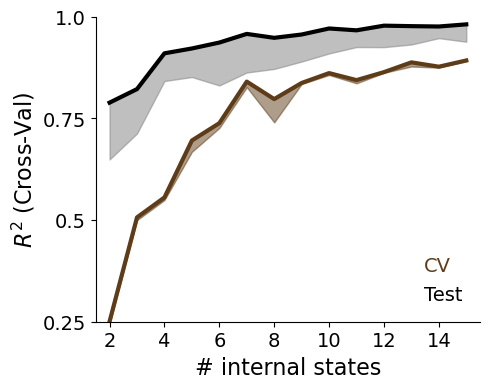

In [ ]:
def darken_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

cols_mouse = np.array(["#5E3C18", "#F5993D", "#A8612A"])
files_results_mouse = natsorted(glob.glob('Results/Mouse/Results_CV_sLDS_Optuna_mouse_100trials_*_states_28112023_RT_noEyeMovModel_AllSubjects_R2score_CVOnly.npz', recursive = True))

cv_scores_mouse = np.zeros((len(files_results_mouse), 100))

for ii, file in enumerate(files_results_mouse):
    a = np.load(file, allow_pickle = True)
    cv_scores_mouse[ii, :] =  a[a.files[0]][()].copy()

meds_cv = np.max(cv_scores_mouse,axis = 1)
# Calculate standard deviations
std_cv = np.percentile(cv_scores_mouse, 75, axis=1)
meds_test = np.max(perf_mouse,axis = 1)
std_test = np.percentile(perf_mouse, 75, axis=1)

x = np.arange(meds_cv.shape[0])+2
fig, ax = plt.subplots(figsize = (5, 4))
plt.plot(x, meds_cv, color=cols_mouse[0], lw = 3, label = 'CV')
plt.fill_between(x, std_cv, meds_cv, color=cols_mouse[0], alpha = 0.5)
plt.ylim([0.25, 1])
plt.ylabel('$R^2$ (Cross-Val)', fontsize=16)
plt.xlabel('# internal states', fontsize=16)

xtiks = np.arange(2, meds_cv.shape[0] + 2)[::2]
plt.xticks(xtiks, xtiks, fontsize=14)
plt.yticks(np.linspace(0.25, 1, 4), np.linspace(0.25, 1, 4), fontsize = 14)
plt.xlim([1.5, meds_cv.shape[0]+1.5])
plt.tight_layout()
#plt.plot(internal_states, perf_mouse, color = 'grey', alpha = 0.3)
plt.plot(internal_states, meds_test, color = 'black', lw = 3, label = 'Test')
plt.fill_between(x, std_test, meds_test, color='grey', alpha = 0.5)
plt.legend(frameon = False, handlelength = 0, labelcolor = 'linecolor', fontsize = 14)
sns.despine()
plt.tight_layout()
plt.savefig('Results/Overfitting_Mouse_Curves_13112024.svg', transparent = True)

In [ ]:
def darken_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

cols_mouse = np.array(["#5E3C18", "#F5993D", "#A8612A"])
# files_results_mouse = natsorted(glob.glob('Results/Mouse/Results_CV_MSLR_Optuna_mouse_newDLC_100trials_*_states_13112024_RT_AllSubjects_R2score_CVOnly.npz', recursive = True))
files_results_mouse = natsorted(glob.glob('Results/Mouse/Results_CV_MSLR_Optuna_mouse_newDLC_100trials_*_states_24022024_RT_AllSubjects_R2score_CVOnly.npz', recursive = True))

cv_scores_mouse = np.zeros((len(files_results_mouse), 100))

for ii, file in enumerate(files_results_mouse):
    a = np.load(file, allow_pickle = True)
    cv_scores_mouse[ii, :] =  a[a.files[0]][()].copy()
    
cv_scores_mouse[cv_scores_mouse<-100] = 0  # Clamp emissions to a maximum of 4
meds_cv = np.max(cv_scores_mouse,axis = 1)
# Calculate standard deviations
std_cv = np.std(cv_scores_mouse, axis=1)
meds_test = np.max(perf_mouse,axis = 1)
std_test = np.std(perf_mouse, axis=1)

max_r2_per_state = {
    state: np.max(r2_scores_per_state[state]) 
    for state in internal_states 
    if state in r2_scores_per_state and len(r2_scores_per_state[state]) > 0
}

std_r2_per_state = {
    state: np.std(r2_scores_per_state[state]) 
    for state in internal_states 
    if state in r2_scores_per_state and len(r2_scores_per_state[state]) > 0
}

plt.figure(figsize = (5,4))
x = np.arange(meds_cv.shape[0])+2
plt.plot(x, meds_cv, color=cols_mouse[0], lw = 3, label = 'CV main')
plt.fill_between(x, meds_cv - std_cv, meds_cv + std_cv, color=cols_mouse[0], alpha = 0.5)

plt.plot(internal_states, meds_test, color = 'black', lw = 3, label = 'Test')
plt.fill_between(x, meds_test - std_test, meds_test + std_test, color='grey', alpha = 0.5)

plt.plot(
    list(max_r2_per_state.keys()), 
    list(max_r2_per_state.values()), 
    linestyle='-', color=cols_mouse[1], lw = 2, label = 'Cross-animals'
)
plt.fill_between(np.array(list(std_r2_per_state.keys())), 
                 np.array(list(max_r2_per_state.values())) - np.array(list(std_r2_per_state.values())),
                 np.array(list(max_r2_per_state.values())) + np.array(list(std_r2_per_state.values())),
                 alpha = 0.2, color = cols_mouse[1]
)

plt.ylabel('R²', fontsize=16)
xtiks = np.arange(2, meds_cv.shape[0] + 2)[::2]

plt.ylim([0.25, 1])
plt.xlabel('# internal states', fontsize=16)
plt.xticks(xtiks, xtiks, fontsize=14)
plt.yticks(np.linspace(0.25, 1, 4), np.linspace(0.25, 1, 4), fontsize = 14)
plt.xlim([1.5, meds_cv.shape[0]+1.5])
plt.legend(frameon = False, handlelength = 0, labelcolor = 'linecolor', fontsize = 14)
plt.tight_layout()
sns.despine()

NameError: name 'r2_scores_per_state' is not defined

Processed 5/29 sessions.
Processed 10/29 sessions.
Processed 15/29 sessions.
Processed 20/29 sessions.
Processed 25/29 sessions.
Processed 29/29 sessions.


"\n# Example: Violin plot for better distribution visualization\nplt.figure(figsize=(5,4))\nsns.violinplot(data=df_a_stats, x='State Pair', y='A_statistic', palette='viridis', inner='quartile')\nplt.title('Pooled A-statistic Across Sessions for Each State Pair')\nplt.xlabel('State Pair')\nplt.ylabel('A-statistic')\nplt.xticks(rotation=45)\nplt.tight_layout()"

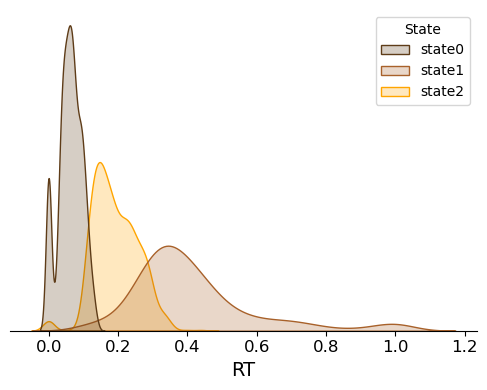

In [ ]:
# Import necessary libraries
import numpy as np
import re
import seaborn as sns
import pandas as pd
import warnings
import BehavUtils as butils
import glob
from natsort import natsorted
from sklearn.metrics import r2_score
from scipy.stats import mannwhitneyu  # Import Mann-Whitney U-test
from itertools import combinations  # For generating state pairs
import matplotlib.pyplot as plt
from collections import defaultdict  # For aggregating R² scores

# Define the number of shuffles and initialize performance arrays
numShuff = 100
perf_mouse = np.full(29, np.nan)
perf_mouse_Sh = np.full((29, numShuff), np.nan)
mouse_1 = np.array([15,16,17,18,19,20,21,22,23,24,25,26])
mouse_2 = np.array([0,1,2,3])
mouse_3 = np.array([4,5,6,7,27,28])
mouse_4 = np.array([8,9,10])
mouse_5 = np.array([11,12])
mouse_6 = np.setdiff1d(np.arange(29), np.concatenate([mouse_1, mouse_2, mouse_3, mouse_4, mouse_5]))

# Organize mouse sessions into a dictionary for easy access
mouse_sessions = {
    'mouse_1': mouse_1,
    'mouse_2': mouse_2,
    'mouse_3': mouse_3,
    'mouse_4': mouse_4,
    'mouse_5': mouse_5,
    'mouse_6': mouse_6
}

# Initialize dictionaries to store training and testing data for each mouse
mouse_data = {
    mouse: {
        'dat_train_list': [],
        'dat_test_list': [],
        'y_train_list': [],
        'y_test_list': []
    } for mouse in mouse_sessions
}

# Define mouse_labels based on your mouse_sessions dictionary
# Assuming 'mouse_sessions' is already defined as per your earlier script
mouse_labels = list(mouse_sessions.keys())

# Glob to find all relevant result files, sorted naturally
result_filename = natsorted(glob.glob(f"Results/Mouse/Results_Test_MSLR_Optuna_mouse_3states_leave_one_out_14112024_RT_AllSubjects_*_session*.npz", recursive=True))

# Initialize dictionaries to collect conditioned emissions and A-statistics
y_test_per_state = defaultdict(list)  # To store emissions per state across all sessions
a_stats = defaultdict(list)           # To store A-statistics per state pair across all sessions
# Initialize list to store conditioned emissions for each session
all_sessions_emissions = []

# Function to compute A-statistic using Mann-Whitney U-test
def compute_a_statistic(x, y):
    if len(x) == 0 or len(y) == 0:
        return np.nan  # Return NaN if one of the distributions is empty
    u_stat, _ = mannwhitneyu(x, y, alternative='two-sided')
    a_stat = u_stat / (len(x) * len(y))
    return a_stat

# Iterate over each result file (each session)
for i, file in enumerate(result_filename):
    a = np.load(file, allow_pickle=True)

    y_test = np.array(a[a.files[0]][()]['y_test'])[:,0]
    preds = np.array(a[a.files[0]][()]['predictions'])[:,0]
    states = np.argmax(np.array(a[a.files[0]][()]['most_likely_states']), axis = 1)
    preds[preds < 0] = 0

    perf_mouse[i] = r2_score(y_test, preds)
    for s in np.arange(numShuff):
        perf_mouse_Sh[i, s] = r2_score(y_test, np.random.permutation(y_test))

    # --------------------------------------------
    # ----- Compute Conditioned Emissions --------
    # --------------------------------------------

    # Identify unique states in the current session
    unique_states = np.unique(states)

    # Generate all possible pairs of states for comparison (if needed)
    state_pairs = list(combinations(unique_states, 2))

    # Iterate over each state to collect emissions
    for state in unique_states:
        emissions = y_test[states == state]
        y_test_per_state[f'state{state}'].extend(emissions)

    # Compute A-statistic for each pair of states (if needed)
    for pair in state_pairs:
        state1, state2 = pair
        emissions1 = y_test[states == state1]
        emissions2 = y_test[states == state2]
        a_stat = compute_a_statistic(emissions1, emissions2)
        a_stats[f'state{state1}_state{state2}'].append(a_stat)

    # ----------------------------------------
    # ----- Collect Conditioned Emissions -----
    # ----------------------------------------

    # Create a DataFrame for the current session
    df_session = pd.DataFrame({
        'State': states,
        'Emission': y_test
    })

    # Ensure 'Emission' is numeric, coercing errors to NaN
    df_session['Emission'] = pd.to_numeric(df_session['Emission'], errors='coerce')

    # Drop rows with NaN in 'Emission'
    #df_session = df_session.dropna(subset=['Emission'])

    # Extract session number from filename for labeling
    match = re.search(r'session(\d+)', file, re.IGNORECASE)
    if match:
        session_num = int(match.group(1))
    else:
        session_num = i + 1  # Fallback to loop index if pattern not found
    
    # Add session identifier to the DataFrame (optional). Assign corrected session number (1-based)
    df_session['Session'] = f'Session {i}'

    # Append the session DataFrame to the list
    all_sessions_emissions.append(df_session)

    # Optional: Print progress every 5 sessions
    if (i + 1) % 5 == 0 or (i + 1) == len(result_filename):
        print(f'Processed {i + 1}/{len(result_filename)} sessions.')

# ----------------------------------------
# ----- Plot Conditioned Distributions ----
# ----------------------------------------

# Convert y_test_per_state to a DataFrame for plotting
data = []
for state, emissions in y_test_per_state.items():
    for emission in emissions:
        data.append({'State': state, 'Emission': emission})
df_emissions = pd.DataFrame(data)

# Plot the conditioned distributions using Seaborn's KDE plots
cols_mouse = sns.color_palette(np.array(["#5E3C18", "#A8612A", 
                                         'orange']))

plt.figure(figsize=(5,4))
sns.kdeplot(data=df_emissions, x='Emission', hue='State', fill=True, common_norm=False, palette=cols_mouse)
plt.xlabel('RT', fontsize = 14)
plt.ylabel('', fontsize = 14)
plt.yticks([])
plt.xticks(fontsize = 12)
sns.despine(left = True)
plt.tight_layout()

# ----------------------------------------
# ----- Plot A-statistic Distributions ----
# ----------------------------------------

# Prepare data for A-statistic plotting
data_a = []
for pair, a_values in a_stats.items():
    for a in a_values:
        data_a.append({'State Pair': pair, 'A_statistic': a})
df_a_stats = pd.DataFrame(data_a)

# Remove NaN A-statistics if any
df_a_stats = df_a_stats.dropna(subset=['A_statistic'])

# ----- Additional: Plot Pooled A-statistic Over Sessions -----
# ----------------------------------------

"""
# Example: Violin plot for better distribution visualization
plt.figure(figsize=(5,4))
sns.violinplot(data=df_a_stats, x='State Pair', y='A_statistic', palette='viridis', inner='quartile')
plt.title('Pooled A-statistic Across Sessions for Each State Pair')
plt.xlabel('State Pair')
plt.ylabel('A-statistic')
plt.xticks(rotation=45)
plt.tight_layout()"""


/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


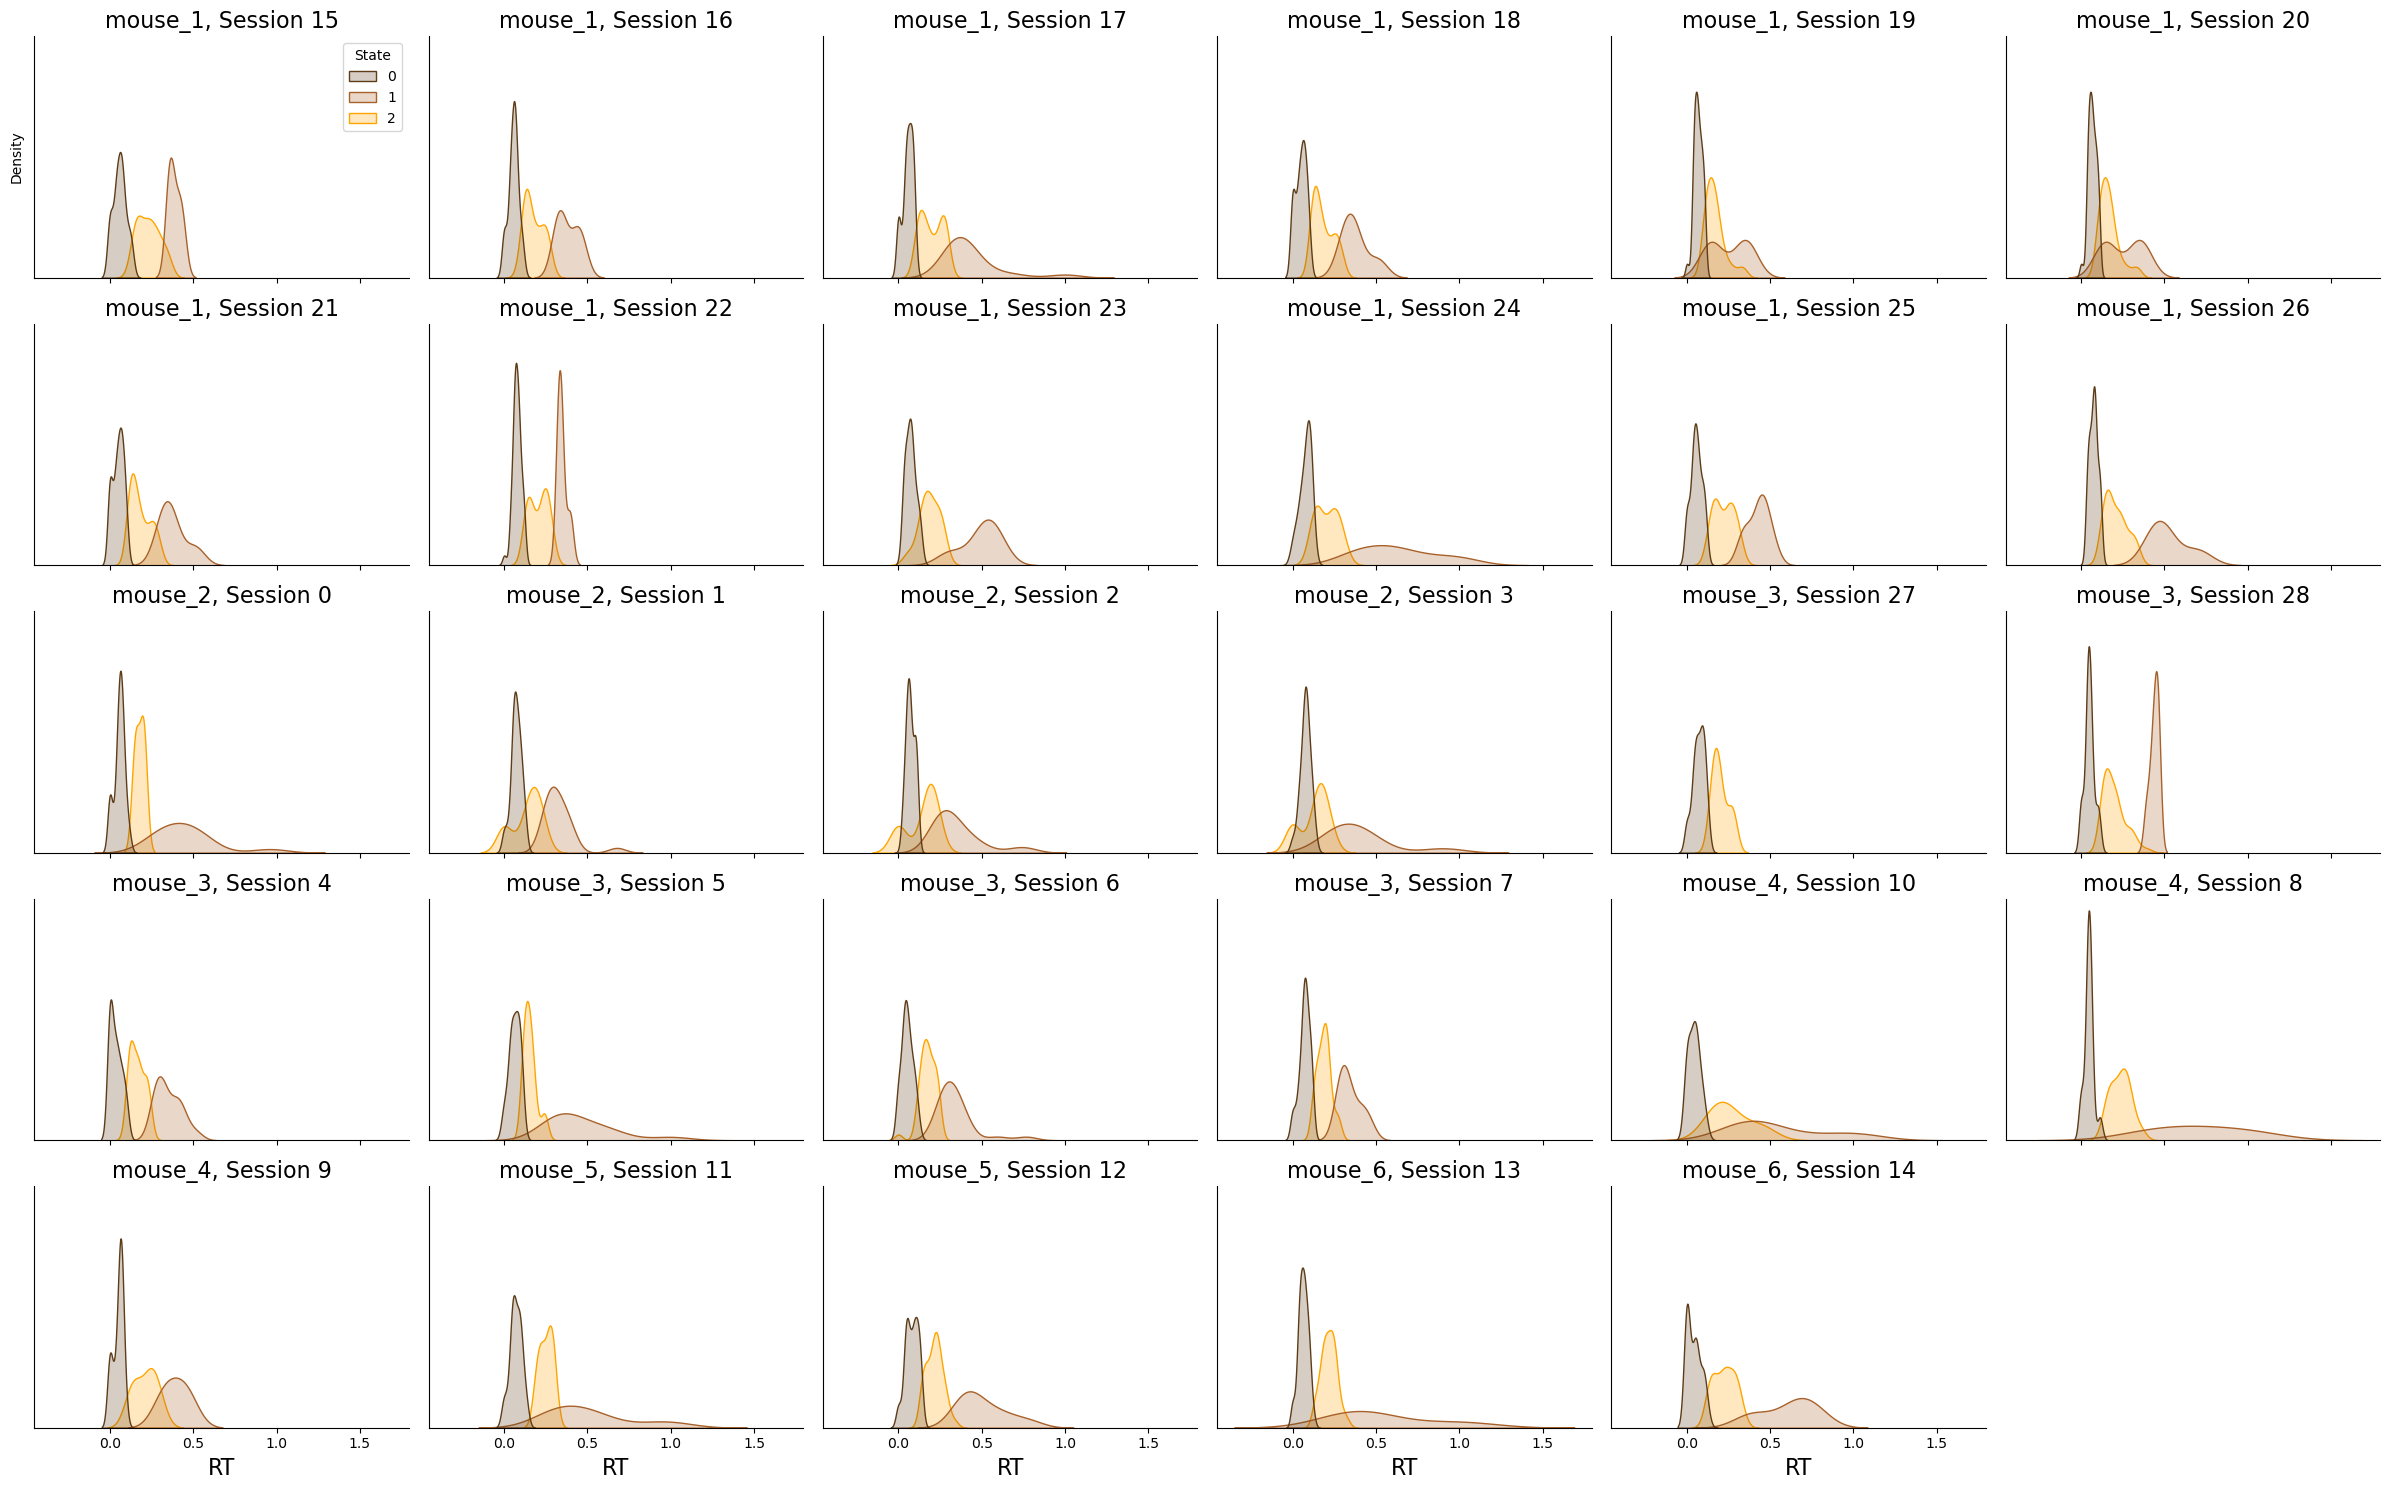

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# Determine the number of sessions
num_sessions = len(all_sessions_emissions)  # Should be 29

# Define subplot grid dimensions (e.g., 5 rows x 6 columns for 30 subplots)
n_rows = 5
n_cols = 6

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each session and plot its conditioned distributions
for idx, df_session in enumerate(all_sessions_emissions):
    ax = axes[idx]
    
    # Extract session label and mouse ID
    session_label = df_session['Session'].iloc[0]
    mouse_id = df_session['Mouse'].iloc[0]
    
    # Plot KDE for each state within the session
    sns.kdeplot(
        data=df_session, 
        x='Emission', 
        hue='State', 
        fill=True, 
        common_norm=False, 
        palette=cols_mouse,  # Replace with 'cols_mouse' if defined
        ax=ax
    )
    
    # Set subplot title with mouse ID and session number
    ax.set_title(mouse_id +', '+ session_label, fontsize = 16)
    
    # Set labels (only on outer subplots to avoid clutter)
    if idx % n_cols == 0:
        ax.set_ylabel('Density')
    else:
        ax.set_ylabel('')
    
    if idx >= (n_rows - 1) * n_cols:
        ax.set_xlabel('RT', fontsize = 16)
    else:
        ax.set_xlabel('')
    ax.set_yticks([])
    # Remove individual legends to avoid repetition
    if idx:
        ax.get_legend().remove()

# Remove any unused subplots (e.g., the 30th subplot)
for j in range(idx + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
sns.despine()

# Save the plot with dynamic date inclusion
date = datetime.now().strftime('%d%m%Y')
plot_save_path = f"Results/Mouse/Emissions_Conditioned_Distributions_per_Session_{date}.png"
plt.savefig(plot_save_path, dpi = 300)


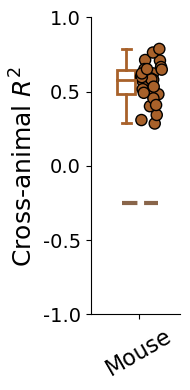

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(2,4))
sns.despine()
cus_pal = sns.color_palette(['#7899c2ff', '#A8612A'][::-1])

sns.boxplot(data = perf_mouse, palette = cus_pal ,showfliers = False, width=0.25, linewidth = 2)

for i, artist in enumerate(ax.patches):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        artist.set_edgecolor(cus_pal[i])
        artist.set_facecolor('None')
        # Each box has 5 associated Line2D objects (because there are no outliers)
        # Loop over them here, and use the same colour as above
        for j in range(i*5,i*5+5):
            line = ax.lines[j]
            line.set_color(cus_pal[i])
            line.set_lw(2)
            line.set_mfc(cus_pal[i])
            line.set_mec(cus_pal[i])


sns.stripplot(data=perf_mouse, palette=cus_pal, jitter=0.15, alpha=1, edgecolor='black', linewidth=1, ax=ax, zorder = 1, dodge=False, size = 8)
#sns.swarmplot(data = [perf_mouse, perf_mouse], palette = cus_pal, edgecolor='black', linewidth = 1, size = 8)

# adjust x-limits to make room for stripplot
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 0.25)
# shift the stripplot to the right
for line in ax.collections:
    x, y = line.get_offsets().T
    line.set_offsets(np.c_[x + 0.35, y])
    
ax.set_xticks(ticks = [0.1775], labels = ['Mouse'], fontsize = 16, rotation = 30)
#ax.set_yticks(ticks = np.linspace(-1., 1, 5), labels = ['{:.1f}'.format(a) for a in np.linspace(-1., 1, 5)], fontsize = 14)
ax.set_yticks(ticks = np.linspace(-1, 1, 5), labels = ['{:.1f}'.format(a) for a in np.linspace(-1, 1, 5)], fontsize = 14)
ax.set_ylabel('Cross-animal $R^2$', fontsize = 18)
plt.axhline(np.percentile(perf_mouse_Sh,99), xmin = 0.35, xmax = 0.75, color = sns.desaturate('#A8612A',0.5), lw = 3, ls = '--')
plt.tight_layout()
#plt.savefig('Results/BothSpecies_AllSubjects_R2_Test_RT_27022024.svg', transparent = True)

## Auto-regressive HMM

In [ ]:
import glob
import numpy as np
from natsort import natsorted
import seaborn as sns
import matplotlib.pyplot as plt
import matplotx as mpx

files_results_macaque_ARHMM = natsorted(glob.glob('ARHMM_CVscores_macaque_*06112023.npy', recursive = True))
cv_scores_macaque_ARHMM = np.zeros((len(files_results_macaque_ARHMM), 50))
for ii, file in enumerate(files_results_macaque_ARHMM):
    cv_scores_macaque_ARHMM[ii,:] = np.load(file)

files_results_mouse_ARHMM = natsorted(glob.glob('ARHMM_CVscores_mouse_*06112023.npy', recursive = True))
cv_scores_mouse_ARHMM = np.zeros((len(files_results_mouse_ARHMM), 50))
for ii, file in enumerate(files_results_mouse_ARHMM):
    cv_scores_mouse_ARHMM[ii,:] = np.load(file)


files_results_macaque = natsorted(glob.glob('Results/Macaque/Results_CV_sLDS_Optuna_macaque_100trials_*_states_28112023_RT_noLEyeBrModel_AllSubjects_R2score_CVOnly.npz', recursive = True))
cv_scores_macaque_fullModel = np.zeros((len(files_results_macaque), 100))
for ii, file in enumerate(files_results_macaque):
    a = np.load(file, allow_pickle = True)
    cv_scores_macaque_fullModel[ii, :] =  a[a.files[0]][()].copy()

files_results_mouse = natsorted(glob.glob('Results/Mouse/Results_CV_sLDS_Optuna_mouse_100trials_*_states_28112023_RT_noEyeMovModel_AllSubjects_R2score_CVOnly.npz', recursive = True))
cv_scores_mouse_fullModel = np.zeros((len(files_results_mouse), 100))
for ii, file in enumerate(files_results_mouse):
    a = np.load(file, allow_pickle = True)
    keyss = list(a.keys())
    cv_scores_mouse_fullModel[ii, :] =  a[a.files[0]][()].copy()


fig, ax = plt.subplots(ncols=2, figsize=(9, 4))
sns.despine()
colors = ['#7899c2ff', '#A8612A']
xlocs = np.arange(2, cv_scores_macaque_fullModel.shape[0]+2)
plot_test_performance(cv_scores_macaque_fullModel.T, xlocs, colors[0], ax[0])
ax[0].plot(xlocs, np.nanmedian(cv_scores_macaque_fullModel, axis = 1), label = 'Face', color = colors[0])
plot_test_performance(cv_scores_macaque_ARHMM.T, xlocs, 'gray', ax[0])
ax[0].plot(xlocs, np.nanmedian(cv_scores_macaque_ARHMM, axis = 1), label = 'ARHMM', color = 'gray')
plot_test_performance(cv_scores_mouse_fullModel.T, xlocs, colors[1], ax[1])
ax[1].plot(xlocs, np.nanmedian(cv_scores_mouse_fullModel, axis = 1), label = 'Face', color = colors[1])
plot_test_performance(cv_scores_mouse_ARHMM.T, xlocs, 'gray', ax[1])
ax[1].plot(xlocs, np.nanmedian(cv_scores_mouse_ARHMM, axis = 1), label = 'ARHMM', color = 'gray')

# Set plot properties
for ii, axi in enumerate(ax):
    axi.set_ylim([-.6, 1])
    axi.set_ylabel('$R^2$ (Cross-Val)', fontsize=16)
    axi.set_xlabel('# internal states', fontsize=16)
    xtiks = np.arange(2, cv_scores_mouse_ARHMM.shape[0] + 2)[::2]
    axi.set_xticks(xtiks)
    axi.set_xticklabels(xtiks, fontsize=14)
    #axi.set_yticks(np.linspace(-2, 1, 7), np.linspace(-2, 1, 7), fontsize = 14)
    axi.set_yticks(np.linspace(-0.5, 1, 4), np.linspace(-0.5, 1, 4), fontsize = 16)
    axi.legend(frameon = False, handlelength = 0, labelcolor = 'linecolor', fontsize = 16)
plt.tight_layout()

plt.savefig('Results/BothSpecies_AllSubjects_numStates_R2_CV_RT_ARHMM_15122023.pdf', transparent = True)

## Dimensionality reduction analyses

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

def supervised_pca(X, y, col, lab, marker):
    # Fit Ridge regression to get feature importances
    clf = Ridge(alpha=0.05, random_state=0)
    clf.fit(X, y.ravel())
    feature_importances = np.abs(clf.coef_[0])

    # Weight the standardized features by their importances
    X_weighted = X * feature_importances

    # Apply PCA to the weighted features
    pca = PCA()
    X_pca = pca.fit_transform(X_weighted)

    # Calculate the variance explained by each component
    pca_variance = pca.explained_variance_ratio_

    plt.plot(np.arange(1, pca_variance.shape[0]+1), np.cumsum(pca_variance), '-', marker = marker, color = col, label = lab, mfc = 'white', lw = 2, mew = 2, ms = 8)
    plt.xlabel('Number of PCA Components', fontsize = 16)
    plt.xticks(np.arange(1, pca_variance.shape[0]+1),np.arange(1, pca_variance.shape[0]+1), fontsize = 14)
    plt.yticks(np.linspace(0, 1, 3),np.linspace(0, 1, 3), fontsize = 14)
    plt.ylabel('Cumulative Explained Variance', fontsize = 16)

    elbow = find_elbow_point(np.arange(1, pca_variance.shape[0]+1), np.cumsum(pca_variance))
    plt.axvline(elbow, color = col, ls = '--')

    pca_fin = PCA(n_components = elbow)
    _ = pca_fin.fit_transform(X_weighted)

    return pca_fin


def find_elbow_point(x, y):
    from kneed import KneeLocator

    # Create the KneeLocator object
    kneedle = KneeLocator(x, y, curve='concave', direction='increasing')

    # Find the elbow point
    elbow_point = kneedle.elbow

    return elbow_point

fig, ax = plt.subplots(figsize = (6, 5))
colors = ['#7899c2ff', '#A8612A']
cpca_mouse = supervised_pca(dat_train_mouse, y_train_mouse, colors[1], 'Mouse', 'o')
cpca_macaque = supervised_pca(dat_train_macaque, y_train_macaque, colors[0], 'Macaque', 's')

plt.legend(frameon = False, labelcolor = 'linecolor', handlelength = 0, fontsize = 14)
plt.tight_layout()
sns.despine()
#plt.savefig('cPCA_Both_VarExp.pdf', transparent = True)

In [ ]:
def plot_tsne(dat_train, y_train, ax, cols):
    from sklearn.manifold import TSNE
    # Perform t-SNE
    tsne_results = TSNE(n_components=2, random_state=42, init = 'pca', learning_rate = 'auto').fit_transform(dat_train)
    
    # Scatter plot for t-SNE
    state_colors = [cols[state] for state in y_train]
    ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=state_colors, s=20, edgecolors = 'black', linewidths = 0.5)
    ax.set_xlabel('t-SNE Feature 1')
    ax.set_ylabel('t-SNE Feature 2')
    plt.tight_layout()

    return tsne_results

In [ ]:
from sklearn.metrics import r2_score

numTrials = 100
date = '11122023'
date_mouse = '27022024'

files_results_macaque_decorr = natsorted(glob.glob('Results/Macaque/Results_Test_sLDS_Optuna_macaque_100trials_'+date+'_RT_noLEyeBrModel_AllSubjects_session*.npz', recursive = True))
files_paramImpor_macaque = natsorted(glob.glob('Results/Macaque/*ParamImportance*'+str(numTrials)+'trials_'+date+'_RT_MorePredictors_AllSubjects_session*.npz', recursive = True))

files_results_mouse_decorr = natsorted(glob.glob('Results/Mouse/Results_Test_MSLR_Optuna_mouse_newDLC_100trials_'+date_mouse+'_RT_AllSubjects_session*.npz', recursive = True))
with open('RawData/Macaque/files_logs_macaque_moreSes.txt') as f:
    files_logs_macaque = [line.strip() for line in f.readlines()]
    
with open('RawData/Mouse/files_logs_mouse_moreSes.txt') as f:
    files_logs_mouse = [line.strip() for line in f.readlines()]

subjects_macaque = ['Cosmos', 'Karl']
stickiness_macaque, concentration_macaque, predictions_macaque, X_test_macaque, y_test_macaque, numStates_macaque, predicted_states_macaque, predicted_statesProbs_macaque, transitionMatrices_macaque, weights_macaque, errorTrials_macaque = [], [], [], [], [], [], [], [], [], [], []
cv_scores_macaque = []
for file in files_results_macaque_decorr:
    a = np.load(file, allow_pickle = True)

    X_test_macaque.append(a[a.files[0]][()]['X_test'])
    y_test_macaque.append(a[a.files[0]][()]['y_test'])
    predictions_macaque.append(a[a.files[0]][()]['predictions'])
    numStates_macaque.append(a[a.files[0]][()]['numStates'])
    concentration_macaque.append(a[a.files[0]][()]['concentration'])
    stickiness_macaque.append(a[a.files[0]][()]['stickiness'])
    predicted_states_macaque.append(a[a.files[0]][()]['predicted_states'])
    predicted_statesProbs_macaque.append(a[a.files[0]][()]['predicted_statesProbs'])
    transitionMatrices_macaque.append(a[a.files[0]][()]['transitionMatrices'])
    weights_macaque.append(a[a.files[0]][()]['weights'])

numShuff = 100
perf_macaque = np.full(len(y_test_macaque), np.nan)
perf_macaque_Sh = np.full((len(y_test_macaque), numShuff), np.nan)

for i in range(len(y_test_macaque)):
    preds = np.array(predictions_macaque[i])
    preds[preds<0] = 0
    perf_macaque[i] = r2_score(y_test_macaque[i], preds)#, squared = False)
    for s in np.arange(numShuff):
        perf_macaque_Sh[i,s] = r2_score(y_test_macaque[i], np.random.permutation(y_test_macaque[i]))#, squared = False)


with open('RawData/Mouse/files_logs_mouse_moreSes.txt') as f:
    files_logs_mouse = [line.strip() for line in f.readlines()]
    
subjects_mouse = ['001', '003', '004', '005', '012', '013']
stickiness_mouse, concentration_mouse, predictions_mouse, X_test_mouse, y_test_mouse, numStates_mouse, predicted_states_mouse, predicted_statesProbs_mouse, transitionMatrices_mouse, weights_mouse, errorTrials_mouse = [], [], [], [], [], [], [], [], [], [], []
cv_scores_mouse = []
for file in files_results_mouse_decorr:
    a = np.load(file, allow_pickle = True)

    X_test_mouse.append(a[a.files[0]][()]['X_test'])
    y_test_mouse.append(a[a.files[0]][()]['y_test'])
    predictions_mouse.append(a[a.files[0]][()]['predictions'])
    numStates_mouse.append(a[a.files[0]][()]['numStates'])
    concentration_mouse.append(a[a.files[0]][()]['concentration'])
    stickiness_mouse.append(a[a.files[0]][()]['stickiness'])
    predicted_states_mouse.append(a[a.files[0]][()]['predicted_states'])
    predicted_statesProbs_mouse.append(a[a.files[0]][()]['predicted_statesProbs'])
    transitionMatrices_mouse.append(a[a.files[0]][()]['transitionMatrices'])
    weights_mouse.append(a[a.files[0]][()]['weights'])

numShuff = 100
perf_mouse = np.full(len(y_test_mouse), np.nan)
perf_mouse_Sh = np.full((len(y_test_mouse), numShuff), np.nan)

for i in range(len(y_test_mouse)):
    preds = np.array(predictions_mouse[i])
    preds[preds<0] = 0
    perf_mouse[i] = r2_score(y_test_mouse[i], preds)#, squared = False)
    for s in np.arange(numShuff):
        perf_mouse_Sh[i,s] = r2_score(y_test_mouse[i], np.random.permutation(y_test_mouse[i]))#, squared = False)

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (11, 5))
tsne_results_macaque = plot_tsne(np.concatenate(X_test_macaque), np.concatenate(predicted_states_macaque), ax = ax[0], cols = cols_macaque)
tsne_results_mouse = plot_tsne(np.concatenate(X_test_mouse), np.concatenate(predicted_states_mouse), ax = ax[1], cols = cols_mouse)

sns.despine()
for axi in ax:
    axi.set_xticks([])
    axi.set_yticks([])
    axi.set_ylabel('t-SNE 2', fontsize = 20)
    axi.set_xlabel('t-SNE 1', fontsize = 20)

ax[0].set_title('Macaque', fontsize = 20)
ax[1].set_title('Mouse', fontsize = 20)
plt.tight_layout()
plt.savefig('tSNE_Both_13112023.png', dpi = 400, transparent = True)